# NORDic package

**Abstract**

[NORDic](https://github.com/clreda/NORDic) is an open-source package which allows to focus on a network-oriented approach to identify regulatory mechanisms linked to a disease, and identify genes of interest.

## Citation

If you use NORDic in published research, please cite the following preliminary work:

> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.

## Install NORDic (with PyPI)

In [1]:
! pip install --no-cache-dir NORDic==1.0.6

In [2]:
! pip list --format=columns | grep NORDic

NORDic               1.0.6


In [1]:
import NORDic

## Network Identification (NORDic NI)

Let us identify a regulatory network which involves genes associated with Congenital Central Hypoventilation syndrome (also called "Ondine syndrome"), from scratch.

In [2]:
from NORDic.NORDic_NI.functions import network_identification, solution2cytoscape
from NORDic.UTILS.utils_grn import load_grn

### Parameters

A rule of thumb to decide which parameters to choose:
- First choose score=0 in the STRING arguments, thres_iscale=None in the LINCS arguments, tau=0 to select all possible edges in the edge-wise arguments, and bin_thres=0.5 to restrict as much as possible experiment-wise in the signature-wise arguments, max_maxclause=3 to consider more simple regulatory functions, and exact=False in the BoneSiS arguments
- If there is an explosion in RAM use (happens for a good personal computer when the number of edges fed to the Boolean network is >3,000), reduce the number of edges by playing with parameters score and tau
- If no model is found, decrease the value of parameter bin_thres in [0,0.5], or increase max_maxclause (leave it smaller than 10, otherwise the RAM goes KABOOM)
- If there are too many models, add more constraints by increasing the value of score, tau, or bin_thres, or setting exact=True (meaning that any solution should use ALL edges fed to the solver)

In [3]:
seed_number=123456
file_folder="MODELS/Ondine/" # where to save the results
path_to_genes=None # path to an existing file with gene names
NETWORK_fname = None # path to an existing network
taxon_id=9606 # human species

DISGENET_args = {
        "credentials": "tests/credentials_DISGENET.txt",
        "disease_cids": ["C1275808"], ## Concept ID of Ondine syndrome
}

STRING_args = {
        "credentials": "tests/credentials_STRING.txt",
        "score": 0, # threshold on the minimum score of STRING edges
}

LINCS_args = {
        "path_to_lincs": "lincs/",
        "credentials": "tests/credentials_LINCS.txt",
        "cell_lines": ["NPC", "SHSY5Y"], # brain cell lines in LINCS L1000
        "thres_iscale": None, # threshold to filter out experiments from LINCS L1000
}

EDGE_args = {
        "tau": 0, # filter edges according to the genepairwise expression correlation
        "filter": True, # whether to apply the filter
        "connected": True, # whether to preserve the connectivity of the network
}

SIG_args = {
        "bin_thres": 0.5, # threshold to binarize gene expression values
}

DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

BONESIS_args = {
        "limit": 1,
        "exact": True,
        "max_maxclause": 3, # quantifies the complexity of the regulatory functions
}

from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)

### Network identification

In [6]:
solution = network_identification(file_folder, taxon_id, path_to_genes, disgenet_args=DISGENET_args, string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY, seed=seed_number, network_fname=NETWORK_fname, njobs=njobs)

1 solutions are already generated, and saved at MODELS/Ondine/SOLUTIONS-1_binthres=0.500_score=0.00_maxclause=3_{1,...1}.zip
--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...1 solutions (1 unique solutions)
... 1 solutions (0/6 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 20 edges
<MODEL VISUALIZATION> Maximal solution: 20 edges
            1
GTP  0.870143
<MODEL SELECTION> Saving optimal model in 'MODELS/Ondine//solution.bnet' ...ASCL1 <- !BDNF&!EDN3&!GDNF&PHOX2B
BDNF <- EDN3|(!ASCL1&!GDNF&!PHOX2B)
EDN3 <- !ASCL1|(BDNF&GDNF&!PHOX2B)
GDNF <- !ASCL1&!BDNF&EDN3&!PHOX2B
PHOX2B <- !BDNF|(ASCL1&!EDN3&!GDNF)

... saved!


In [7]:
if (solution is not None):
    solution = load_grn(file_folder+"solution.bnet")
    ## Convert to Cytoscape-readable file
    solution2cytoscape(solution, file_folder+"solution_cytoscape")

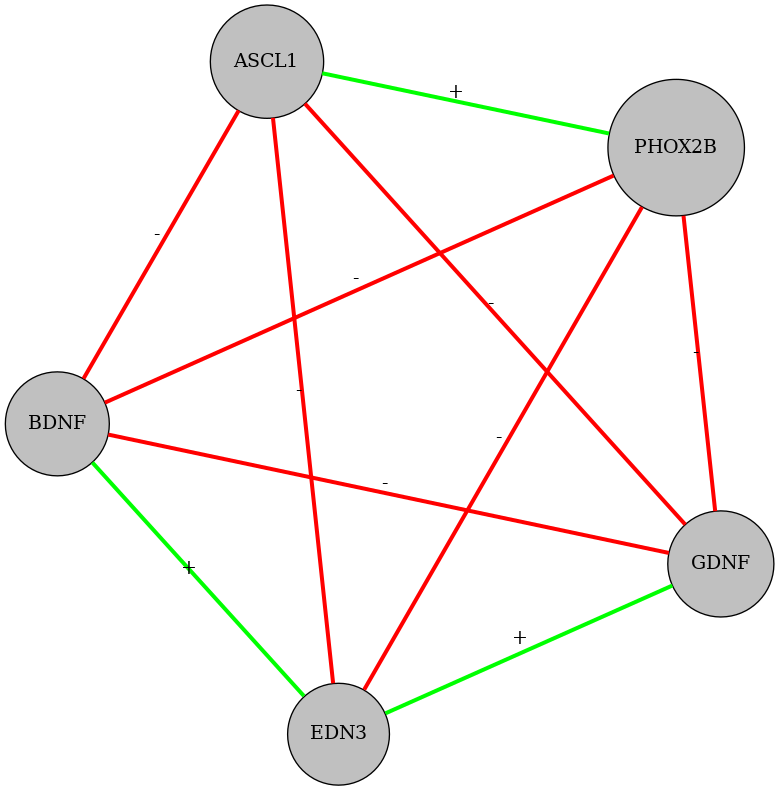

In [8]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

In [9]:
file_folder="MODELS/Ondine/"
with open(file_folder+"solution.bnet", "r") as f:
    network = f.read()
print(network)

ASCL1 <- !BDNF&!EDN3&!GDNF&PHOX2B
BDNF <- EDN3|(!ASCL1&!GDNF&!PHOX2B)
EDN3 <- !ASCL1|(BDNF&GDNF&!PHOX2B)
GDNF <- !ASCL1&!BDNF&EDN3&!PHOX2B
PHOX2B <- !BDNF|(ASCL1&!EDN3&!GDNF)


## Another network identification

The previous network might not be very interesting, due to the small number of genes. NORDic allows feeding an existing network (part 1) or a set of genes (part 2) to the network identification pipeline. In this case, we will consider all direct gene neighbors of the 7 previous genes related to the Ondine syndrome in the PPI from the STRING database, with a high enough evidence score.

### Part 1: Use an existing network

In [33]:
from NORDic.UTILS.STRING_utils import get_interactions_from_STRING

file_folder="MODELS/Ondine_larger_network/"
gene_list = [s.split(" <- ")[0] for s in network.split("\n")]
## Get physical interactions from the STRING database involving the list of genes in input
PPI = get_interactions_from_STRING(gene_list, taxon_id,
                                   min_score=0, app_name="NORDic_package", ## change the STRING app_name to yours
                                   file_folder=file_folder)

<STRING> Retrieving the file from STRING... Saved at MODELS/Ondine_larger_network/protein_action.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes


In [34]:
PPI

preferredName_A preferredName_B  sign  directed  score
0                 ARF5          MAP2K5     2         1  0.173
1                 ARF5          MAP2K5     2         0  0.173
2                 ARF5          MAP2K5    -1         1  0.172
4                 ARF5          PIK3CA     2         0  0.150
5                 ARF5          PRKACA    -1         0  0.156
...                ...             ...   ...       ...    ...
117530            RBPJ         ANKDD1B     1         0  0.171
117537            EEF2           RPS28     2         0  0.900
117539           RAP1B            VAV1     1         0  0.811
117542           PLCG1            VAV1     1         0  0.803
117554            DAZL         SNRNP70     2         0  0.227

[55774 rows x 5 columns]

In [10]:
from subprocess import call
file_folder="MODELS/Ondine_larger/"
call("mkdir -p "+file_folder, shell=True)
NETWORK_fname = file_folder+"full_PPI.tsv"
PPI.to_csv(NETWORK_fname, sep="\t", index=None)

In [29]:
STRING_args.update({"score": 0})
EDGE_args = {
        "tau": 0,
        "filter": False,
        "connected": True,
}
LINCS_args.update({ "thres_iscale": 0.05 })
SIG_args = {
        "bin_thres": 0.35, 
}
BONESIS_args = {
        "limit": 1000,
        "exact": False,
        "max_maxclause": 10,
}
path_to_genes=None
NETWORK_fname = "MODELS/Ondine_larger/full_PPI.tsv"
file_folder="MODELS/Ondine_larger_network_full/"
solution_larger_network_full = NORDic.NORDic_NI.functions.network_identification(file_folder, taxon_id, path_to_genes, disgenet_args=DISGENET_args, string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY, seed=seed_number, network_fname=NETWORK_fname, njobs=njobs)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 342 genes imported.
2. Import network from MODELS/Ondine_larger/full_PPI.tsv... ... 771 edges in model (including 503 directed edges) with a total of 342 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines in which at least one of the genes has been perturbed (['NPC', 'SHSY5Y'])
	157 genes available (convertable to EntrezIDs)
		Check that
		1. All input genes are HUGO Gene Symbols / Ensembl IDs / HGNC IDs / STRING IDs;
		2. The correct taxon id (9606) was provided.
		157/157 genes retrieved in LINCS L1000
		19 unique experiments (including 8 with criterion thres_iscale > 0.05, min_value 0.06423201716220739)
... 134 genes in 52 profiles (8 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 134 genes, 228 unique edges involving genes in experiments
... score_STRING 0.000000	#genes (non isolated in PPI) 134	#edges i

  0%|                                                                                               | 0/1 [00:00<?, ?it/s]

Grounding...done in 2.4s
Found 1000 solutions in 604.2s (first in 2.2s; rate 0.6s)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:07<00:00, 607.89s/it]


--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...1000 solutions (1000 unique solutions)
... 1000 solutions (96/135 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 7 edges
<MODEL VISUALIZATION> Maximal solution: 52 edges
         1         2         3        4         5         6         7     \
GTP  0.784268  0.812842  0.790421  0.78655  0.801205  0.784506  0.804689   

         8         9         10        11        12        13        14    \
GTP  0.803998  0.817377  0.815316  0.813984  0.792177  0.810619  0.810352   

         15        16        17        18        19        20       21    \
GTP  0.805659  0.808136  0.799992  0.801897  0.817645  0.792883  0.79922   

         22        23        24        25        26        27        28    \
GTP  0.806191  0.799694  0.787305  0.793485  0.800453  0.805734  0.801085   

         29        30        31        32        33        34        35    \
GTP  0.806944  0

<MODEL SELECTION> Saving optimal model in 'MODELS/Ondine_larger_network_full//solution.bnet' ...ADAM17 <- 1
ADRB2 <- 1
AGRP <- 1
ALDH1A2 <- BDNF
ALK <- 1
...
... saved!


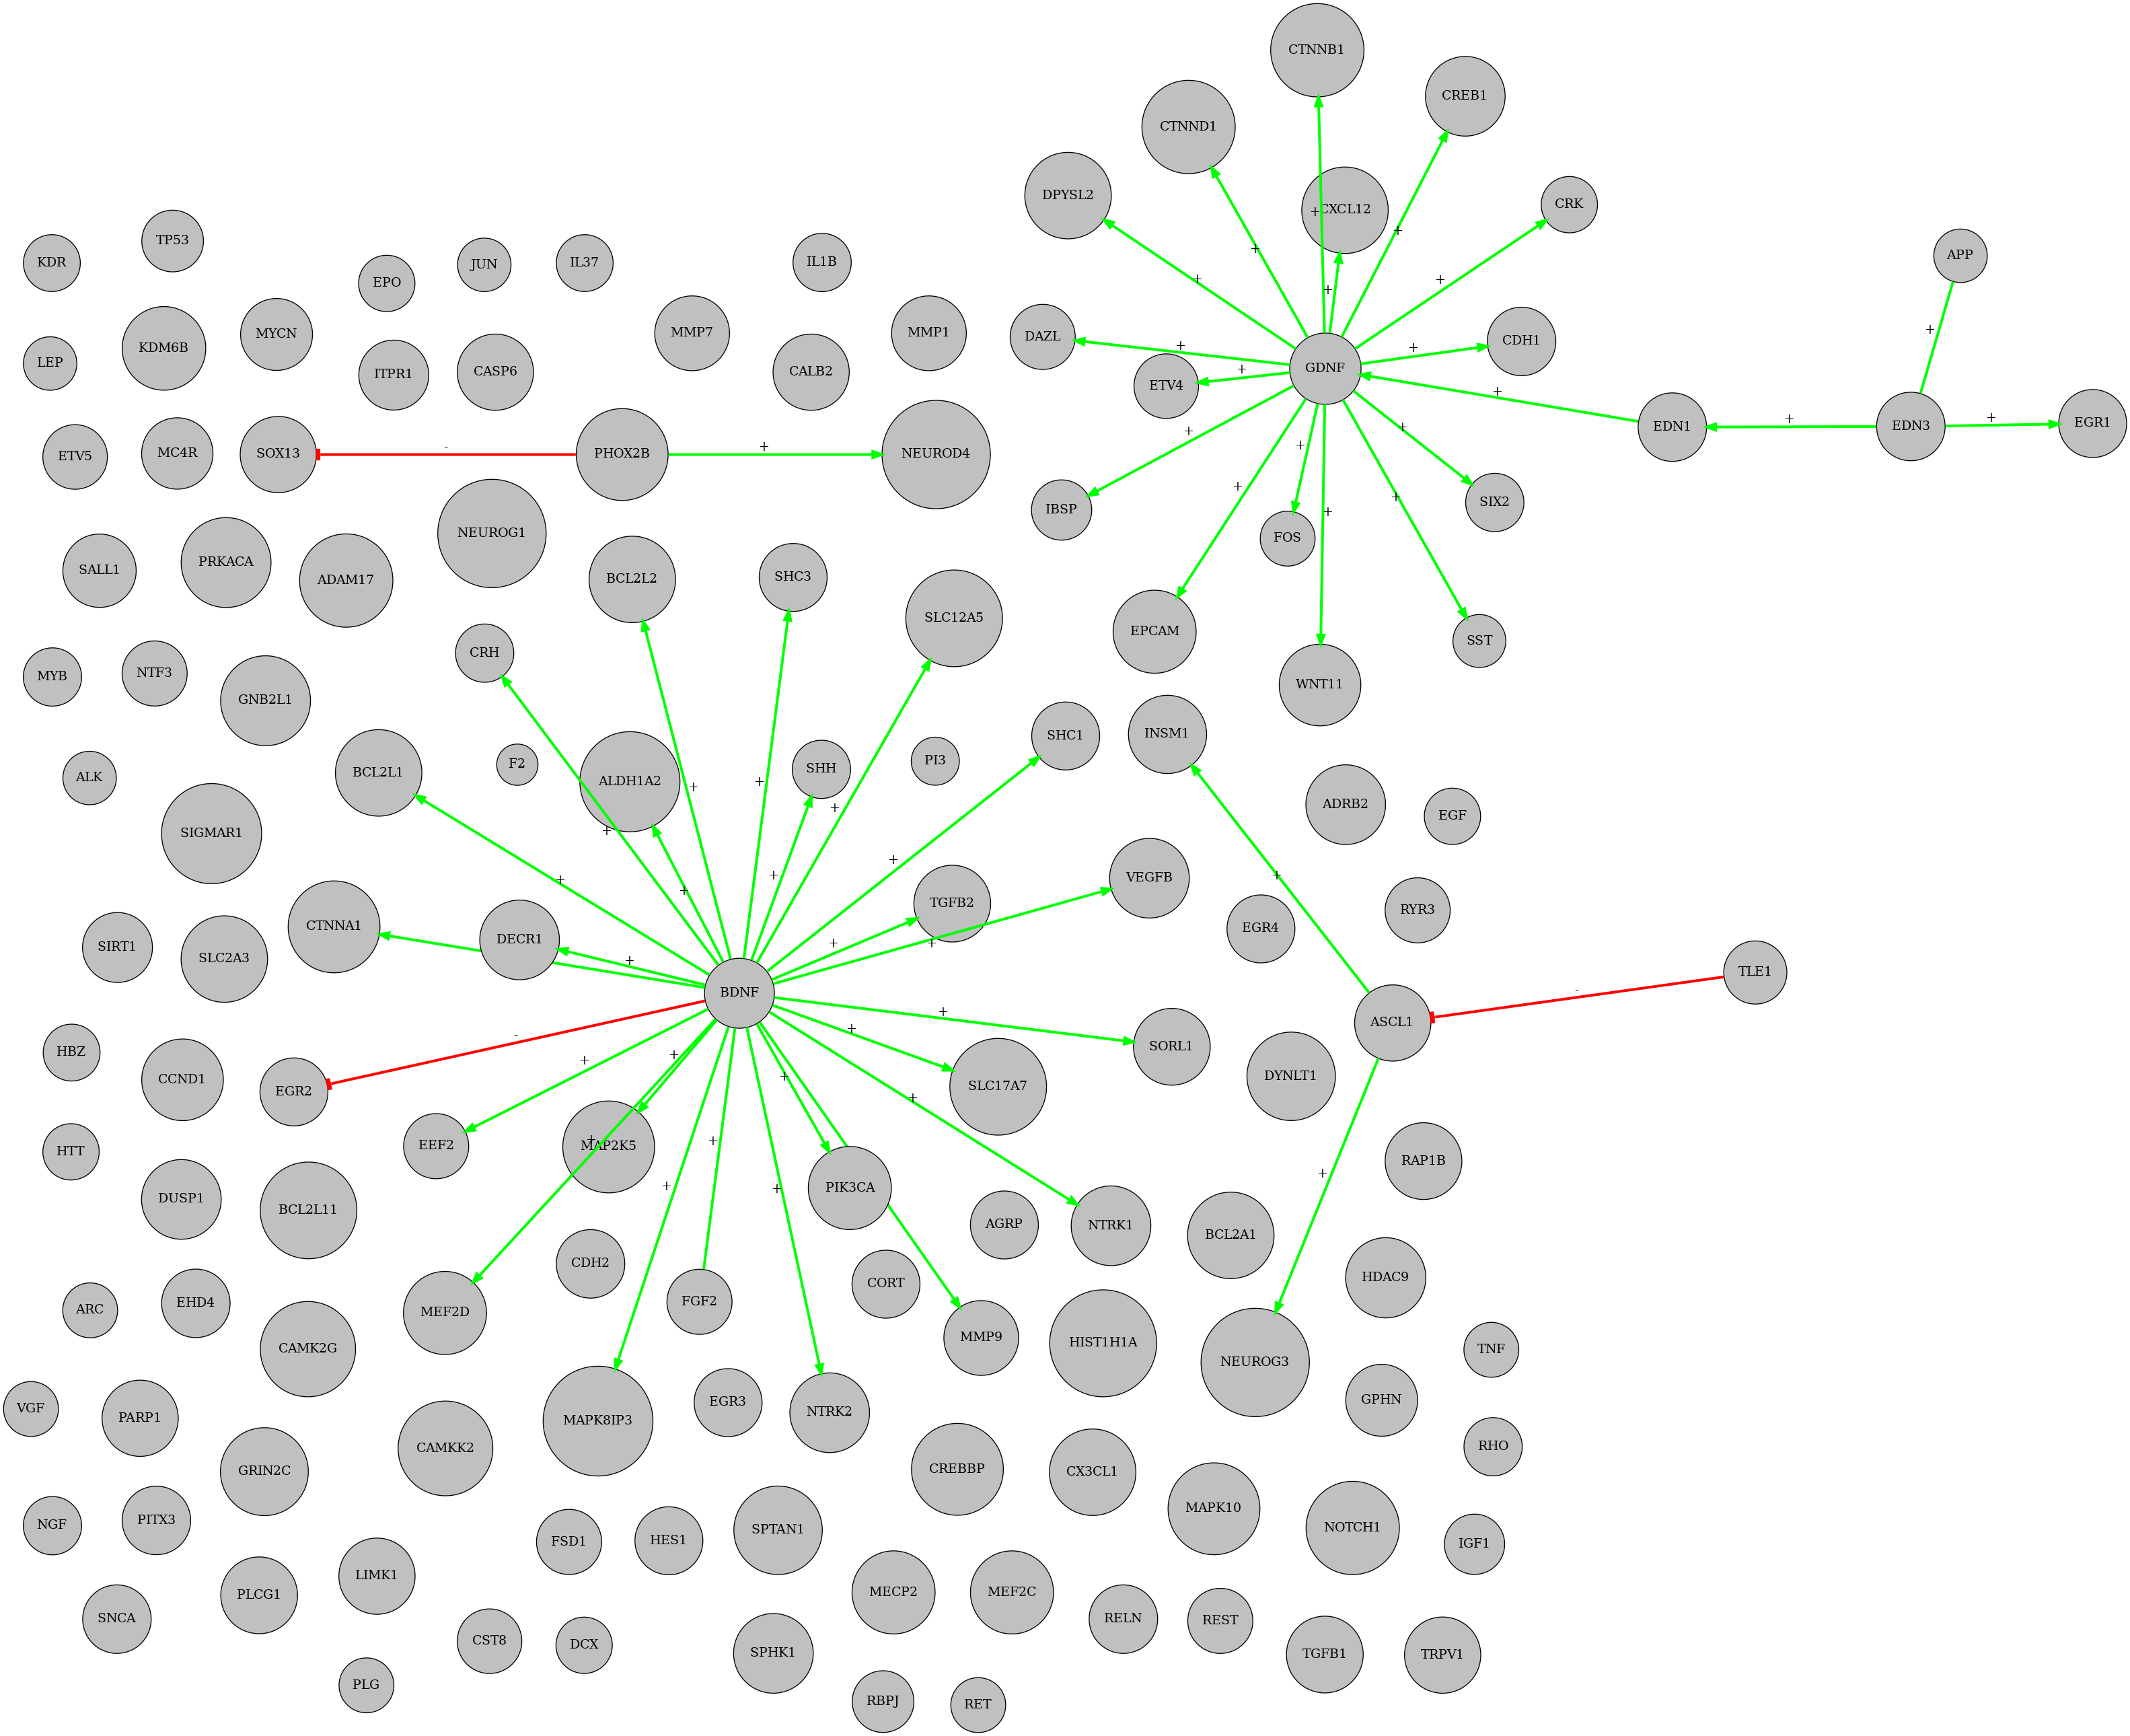

In [30]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

In [31]:
with open(file_folder+"solution.bnet", "r") as f:
    network = f.read()
print(network)

ADAM17 <- 1
ADRB2 <- 1
AGRP <- 1
ALDH1A2 <- BDNF
ALK <- 1
APP <- EDN3
ARC <- 1
ASCL1 <- !TLE1
BCL2A1 <- 1
BCL2L1 <- BDNF
BCL2L11 <- 1
BCL2L2 <- BDNF
BDNF <- FGF2
CALB2 <- 0
CAMK2G <- 1
CAMKK2 <- 0
CASP6 <- 1
CCND1 <- 1
CDH1 <- GDNF
CDH2 <- 1
CORT <- 1
CREB1 <- GDNF
CREBBP <- 0
CRH <- BDNF
CRK <- GDNF
CST8 <- 1
CTNNA1 <- BDNF
CTNNB1 <- GDNF
CTNND1 <- GDNF
CX3CL1 <- 1
CXCL12 <- GDNF
DAZL <- GDNF
DCX <- 1
DECR1 <- BDNF
DPYSL2 <- GDNF
DUSP1 <- 1
DYNLT1 <- 1
EDN1 <- EDN3
EDN3 <- APP
EEF2 <- BDNF
EGF <- 0
EGR1 <- EDN3
EGR2 <- !BDNF
EGR3 <- 1
EGR4 <- 1
EHD4 <- 1
EPCAM <- GDNF
EPO <- 1
ETV4 <- GDNF
ETV5 <- 0
F2 <- 0
FGF2 <- BDNF
FOS <- GDNF
FSD1 <- 1
GDNF <- EDN1
GNB2L1 <- 1
GPHN <- 1
GRIN2C <- 1
HBZ <- 0
HDAC9 <- 1
HES1 <- 0
HIST1H1A <- 1
HTT <- 1
IBSP <- GDNF
IGF1 <- 1
IL1B <- 1
IL37 <- 0
INSM1 <- ASCL1
ITPR1 <- 1
JUN <- 1
KDM6B <- 1
KDR <- 0
LEP <- 1
LIMK1 <- 1
MAP2K5 <- BDNF
MAPK10 <- 1
MAPK8IP3 <- BDNF
MC4R <- 1
MECP2 <- 1
MEF2C <- 1
MEF2D <- BDNF
MMP1 <- 1
MMP7 <- 0
MMP9 <- BDNF
MYB <- 0

Try now with a subset of edges (which are all directed and signed).

In [35]:
## Try with only signed and directed edges
NETWORK_fname = file_folder+"PPI.tsv"
PPI.loc[(PPI["directed"]==1)&(PPI["sign"].abs()==1)].to_csv(NETWORK_fname, sep="\t", index=None)
PPI.loc[(PPI["directed"]==1)&(PPI["sign"].abs()==1)]

preferredName_A preferredName_B  sign  directed  score
2                ARF5          MAP2K5    -1         1  0.172
14             SEMA3F            TP53    -1         1  0.467
27               RALA          MAP2K5    -1         1  0.211
31               RALA          MAPK10     1         1  0.913
50               DVL2          CTNNB1    -1         1  0.900
...               ...             ...   ...       ...    ...
49649           S1PR2           SPHK1     1         1  0.416
49671          MAP2K6             FOS     1         1  0.431
49723            VAV1           PLCG1     1         1  0.900
49726            VAV1            CDH1    -1         1  0.416
49727            VAV1          PIK3CA     1         1  0.900

[6859 rows x 5 columns]

In [7]:
STRING_args.update({"score": 0})
EDGE_args = {
        "tau": 0,
        "filter": False,
        "connected": True,
}
LINCS_args.update({"thres_iscale": 0})
SIG_args = {
        "bin_thres": 0., ## we trust more the edges than the experiments, hence we ignore the experiments here
}
BONESIS_args = {
        "limit": 1000,
        "exact": True, ## we need all edges
        "max_maxclause": 15,
}
path_to_genes=None
NETWORK_fname="MODELS/Ondine_larger/PPI.tsv"
file_folder="MODELS/Ondine_larger_network/"
solution_larger_network = NORDic.NORDic_NI.functions.network_identification(file_folder, taxon_id, path_to_genes, disgenet_args=DISGENET_args, string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY, seed=seed_number, network_fname=NETWORK_fname, njobs=njobs)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 157 genes imported.
2. Import network from MODELS/Ondine_larger/PPI.tsv... ... 184 edges in model (including 184 directed edges) with a total of 157 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines in which at least one of the genes has been perturbed (['NPC', 'SHSY5Y'])
	157 genes available (convertable to EntrezIDs)
		157/157 genes retrieved in LINCS L1000
		19 unique experiments (including 11 with criterion thres_iscale > 0, min_value 0.00969363520536315)
... 134 genes in 72 profiles (11 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 134 genes, 160 unique edges involving genes in experiments
... score_STRING 0.000000	#genes (non isolated in PPI) 134	#edges in PPI 160
2. Build topological constraints from filtered edges using gene expression data...  ...... 138 negative, 14 positive interactions (152 edg

  0%|                                                                                               | 0/1 [00:00<?, ?it/s]

Grounding...done in 4.1s
Found 1000 solutions in 844.3s (first in 2.8s; rate 0.8s)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [14:09<00:00, 849.97s/it]


--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...1000 solutions (1000 unique solutions)
... 1000 solutions (48/135 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 152 edges
<MODEL VISUALIZATION> Maximal solution: 152 edges
         1         2         3         4         5         6         7     \
GTP  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978   

         8         9         10        11        12        13        14    \
GTP  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978   

         15        16        17        18        19        20        21    \
GTP  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978   

         22        23        24        25        26        27        28    \
GTP  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978  0.869978   

         29        30        31        32        33        34        35    \
GTP  0.86

<MODEL SELECTION> Saving optimal model in 'MODELS/Ondine_larger_network//solution.bnet' ...ADAM17 <- 1
ADRB2 <- !BDNF
AGRP <- 1
ALDH1A2 <- BDNF
ALK <- PHOX2B
...
... saved!


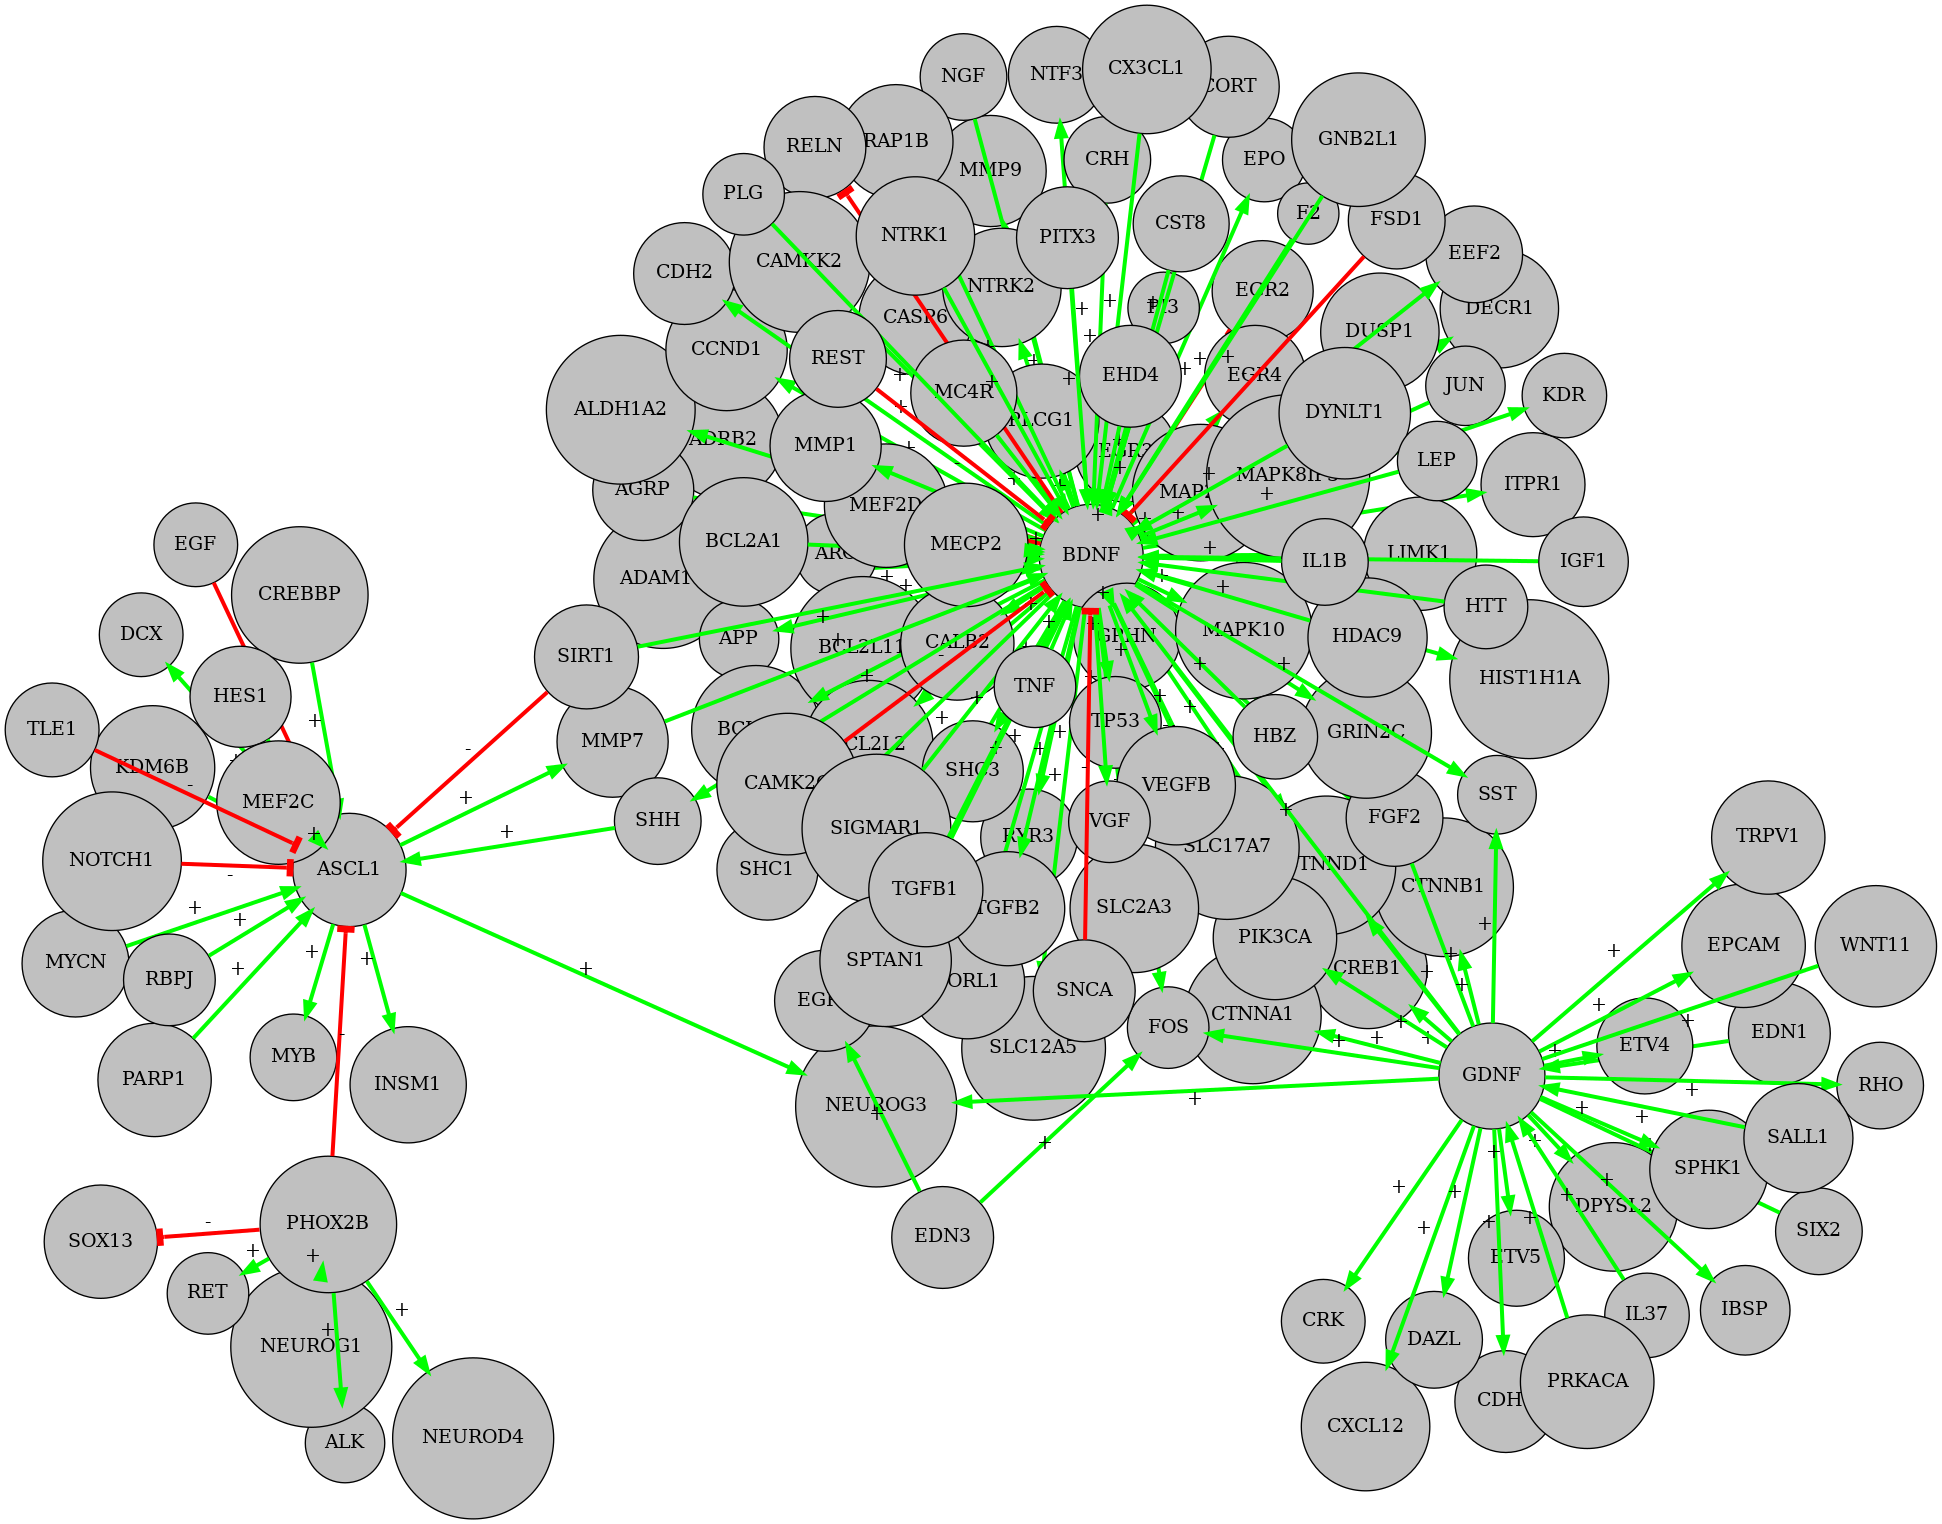

In [8]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

In [9]:
with open(file_folder+"solution.bnet", "r") as f:
    network = f.read()
print(network)

ADAM17 <- 1
ADRB2 <- !BDNF
AGRP <- 1
ALDH1A2 <- BDNF
ALK <- PHOX2B
APP <- BDNF
ARC <- BDNF
ASCL1 <- MEF2C|MYCN|RBPJ|!SIRT1|(CREBBP&!TLE1)|(!EGF&HES1&PARP1&!PHOX2B)|(KDM6B&SHH)|(!NOTCH1&!TLE1)
BCL2A1 <- 1
BCL2L1 <- BDNF
BCL2L11 <- BDNF
BCL2L2 <- BDNF
BDNF <- !REST|SIRT1|(ADAM17&AGRP&BCL2A1&CAMKK2&CREB1&CRH&DYNLT1&EHD4&F2&FGF2&!FSD1&GNB2L1&HTT&IL1B&MECP2&MMP7&NGF&PITX3&PLG&SIGMAR1&!SNCA&SPTAN1)|(!CAMK2G&CORT&CST8&CX3CL1&HBZ&HDAC9&IGF1&JUN&LEP&MC4R&NTRK1)|(GDNF&TGFB1&TNF)
CALB2 <- BDNF
CAMK2G <- 0
CAMKK2 <- 1
CASP6 <- BDNF
CCND1 <- BDNF
CDH1 <- GDNF
CDH2 <- BDNF
CORT <- 1
CREB1 <- BDNF|GDNF
CREBBP <- 1
CRH <- 1
CRK <- GDNF
CST8 <- 1
CTNNA1 <- BDNF|GDNF
CTNNB1 <- BDNF|GDNF
CTNND1 <- BDNF|GDNF
CX3CL1 <- 1
CXCL12 <- GDNF
DAZL <- GDNF
DCX <- ASCL1
DECR1 <- BDNF
DPYSL2 <- GDNF
DUSP1 <- BDNF
DYNLT1 <- 1
EDN1 <- 0
EDN3 <- 1
EEF2 <- BDNF
EGF <- 1
EGR1 <- BDNF&EDN3
EGR2 <- !BDNF
EGR3 <- BDNF
EGR4 <- BDNF
EHD4 <- 1
EPCAM <- GDNF
EPO <- BDNF
ETV4 <- GDNF
ETV5 <- GDNF
F2 <- 1
FGF2 <- BDNF|GDNF
FOS <-

### Part 2 : Use an existing set of genes

In [20]:
import pandas as pd
file_folder="MODELS/Ondine_larger/"
NETWORK_fname = file_folder+"PPI.tsv"
PPI = pd.read_csv(NETWORK_fname, sep="\t")
ppi = PPI.loc[(PPI["directed"]==1)&(PPI["sign"].abs()==1)]
genes = list(set(list(ppi["preferredName_A"])+list(ppi["preferredName_B"])))
with open(file_folder+"genes.txt", "w") as f:
    f.write("\n".join(genes))
NETWORK_fname=None

In [ ]:
##########TODO
STRING_args.update({"score": 0})
EDGE_args = {
        "tau": 0,
        "filter": True,
}
SIG_args = {
        "bin_thres": 0.5, 
}
BONESIS_args = {
        "limit": 1,
        "exact": False,
        "max_maxclause": 3,
}
path_to_genes = "MODELS/Ondine_larger/genes.txt"
file_folder="MODELS/Ondine_larger_genes/"
solution_larger = network_identification(file_folder, taxon_id, path_to_genes, disgenet_args=DISGENET_args, string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args, sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY, seed=seed_number, network_fname=NETWORK_fname, njobs=njobs)

--- DATA IMPORT ---
1. Import gene set from MODELS/Ondine_larger/genes.txt... ... 156 genes imported.
2. Import network from MODELS/Ondine_larger/PPI.tsv... ... 184 edges in model (including 184 directed edges) with a total of 157 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines in which at least one of the genes has been perturbed (['NPC', 'SHSY5Y'])
	154 genes available (convertable to EntrezIDs)
		Check that
		1. All input genes are HUGO Gene Symbols / Ensembl IDs / HGNC IDs / STRING IDs;
		2. The correct taxon id (9606) was provided.
		154/154 genes retrieved in LINCS L1000
<UTILS_EXP> Gene 1/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 2/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 3/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 4/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 5/154 Cell 1/2 Type 1/3
	<UTILS_EXP> (SIK1,NPC,trt_sh): 3
<UTILS_EXP> Gene 6/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 7/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 8/154 Cell 1/2 Type 1/3
<UTILS_EXP> Gene 9/154 Cel

<UTILS_EXP> 0 experiments so far
	<UTILS_EXP> Treatment SIK1 (entrez_id 102724428)... <BioDBNet> 1/1
<LINCS> 3 TREATED experiments ('brew_prefix') (3 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.28221
<LINCS> 3 same-plate profiles
<LINCS> 26 CONTROL experiments ('brew_prefix') (4 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 5.43136
<LINCS> 3 same-plate profiles
<UTILS_EXP> 0 experiments so far
	<UTILS_EXP> Treatment FSD1 (entrez_id 79187)... <BioDBNet> 1/1
<LINCS> 3 TREATED experiments ('brew_prefix') (4 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.1146
<LINCS> 4 same-plate profiles
<LINCS> 22 CONTROL experiments ('brew_prefix') (6 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 7.20206
<LINCS> 4 same-plate profiles
<INTERFERENCE SCALE> KD Perturbed 79187 = 1.00097 || Most stable control 1915 = 0.99718
<INTERFERENCE SCALE> -0.00379
... 132 genes, 8 profiles
<UTILS_EXP> 1 experiments so far
	<UTILS_EXP> Duplicated trea

<LINCS> 3 TREATED experiments ('brew_prefix') (4 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.51317
<LINCS> 4 same-plate profiles
<LINCS> 21 CONTROL experiments ('brew_prefix') (6 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 4.39192
<LINCS> 3 same-plate profiles
<INTERFERENCE SCALE> KD Perturbed 2353 = 0.81445 || Most stable control 7846 = 1.00000
<INTERFERENCE SCALE> 0.18555
... 132 genes, 7 profiles
<UTILS_EXP> 10 experiments so far
	<UTILS_EXP> Duplicated treatment:FOS, cell:NPC, type:trt_sh
<UTILS_EXP> 10 experiments so far
	<UTILS_EXP> Duplicated treatment:FOS, cell:NPC, type:trt_sh
<UTILS_EXP> Gene 1/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 2/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 3/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 4/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 5/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 6/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 7/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 8/154 Cell 1/2 Type 2/3
<UTILS_EXP> Gene 9/154 Cell 1/2 Type 2/3


<UTILS_EXP> Gene 27/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 28/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 29/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 30/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 31/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 32/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 33/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 34/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 35/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 36/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 37/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 38/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 39/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 40/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 41/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 42/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 43/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 44/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 45/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 46/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 47/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 48/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 49/154 Cell 1/2 Type 3/3
<UTILS_EXP> Gene 50/154 Cell 1/2 T

	<UTILS_EXP> (HDAC9,SHSY5Y,trt_sh): 3
<UTILS_EXP> Gene 65/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 66/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 67/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 68/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 69/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 70/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 71/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 72/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 73/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 74/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 75/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 76/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 77/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 78/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 79/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 80/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 81/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 82/154 Cell 2/2 Type 1/3
	<UTILS_EXP> (PTPN5,SHSY5Y,trt_sh): 3
<UTILS_EXP> Gene 83/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 84/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 85/154 Cell 2/2 Type 1/3
<UTILS_EXP> Gene 86/154 Cell 2/2 Type 1/3


<UTILS_EXP> 14 experiments so far
	<UTILS_EXP> Treatment SIRT1 (entrez_id 23411)... <BioDBNet> 1/1
<LINCS> 3 TREATED experiments ('brew_prefix') (3 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.42886
<LINCS> 3 same-plate profiles
<LINCS> 18 CONTROL experiments ('brew_prefix') (5 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.75211
<LINCS> 3 same-plate profiles
<INTERFERENCE SCALE> KD Perturbed 23411 = 1.05372 || Most stable control 7846 = 1.00000
<INTERFERENCE SCALE> -0.05372
... 132 genes, 6 profiles
<UTILS_EXP> 15 experiments so far
	<UTILS_EXP> Duplicated treatment:SIRT1, cell:SHSY5Y, type:trt_sh
<UTILS_EXP> 15 experiments so far
	<UTILS_EXP> Duplicated treatment:SIRT1, cell:SHSY5Y, type:trt_sh
<UTILS_EXP> 15 experiments so far
	<UTILS_EXP> Treatment NEUROD4 (entrez_id 58158)... <BioDBNet> 1/1
<LINCS> 3 TREATED experiments ('brew_prefix') (3 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 4.38195
<LINCS> 3 same-plate profiles
<LINCS> 

<UTILS_EXP> Gene 113/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 114/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 115/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 116/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 117/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 118/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 119/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 120/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 121/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 122/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 123/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 124/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 125/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 126/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 127/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 128/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 129/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 130/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 131/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 132/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 133/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 134/154 Cell 2/2 Type 2/3
<UTILS_EXP> Gene 135/154 Cell 2/2 Type 2/3
<UTILS_EXP>

<UTILS_EXP> Gene 153/154 Cell 2/2 Type 3/3
<UTILS_EXP> Gene 154/154 Cell 2/2 Type 3/3
		19 unique experiments (including 11 with criterion thres_iscale > 0, min_value 0.00969363520536315)
... 133 genes in 72 profiles (11 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 133 genes, 159 unique edges involving genes in experiments
... score_STRING 0.000000	#genes (non isolated in PPI) 133	#edges in PPI 14084
2. Build topological constraints from filtered edges using gene expression data...  ...... 3540 negative, 3502 positive interactions (7042 edges in total), 133 non isolated genes in experiments
3. Build dynamical constraints by binarization of experimental profiles...  ...... 11 experiments on 2 cell lines and 133/133 genes (Frobenius norm signature matrix: 41.581, 3 possibly constant genes: 2.3%, 0 genes with undetermined status

--- INFER BOOLEAN NETWORK ---
1. Generate solutions from topolo

  0%|                                                                                               | 0/1 [00:00<?, ?it/s]

Grounding...done in 66.2s


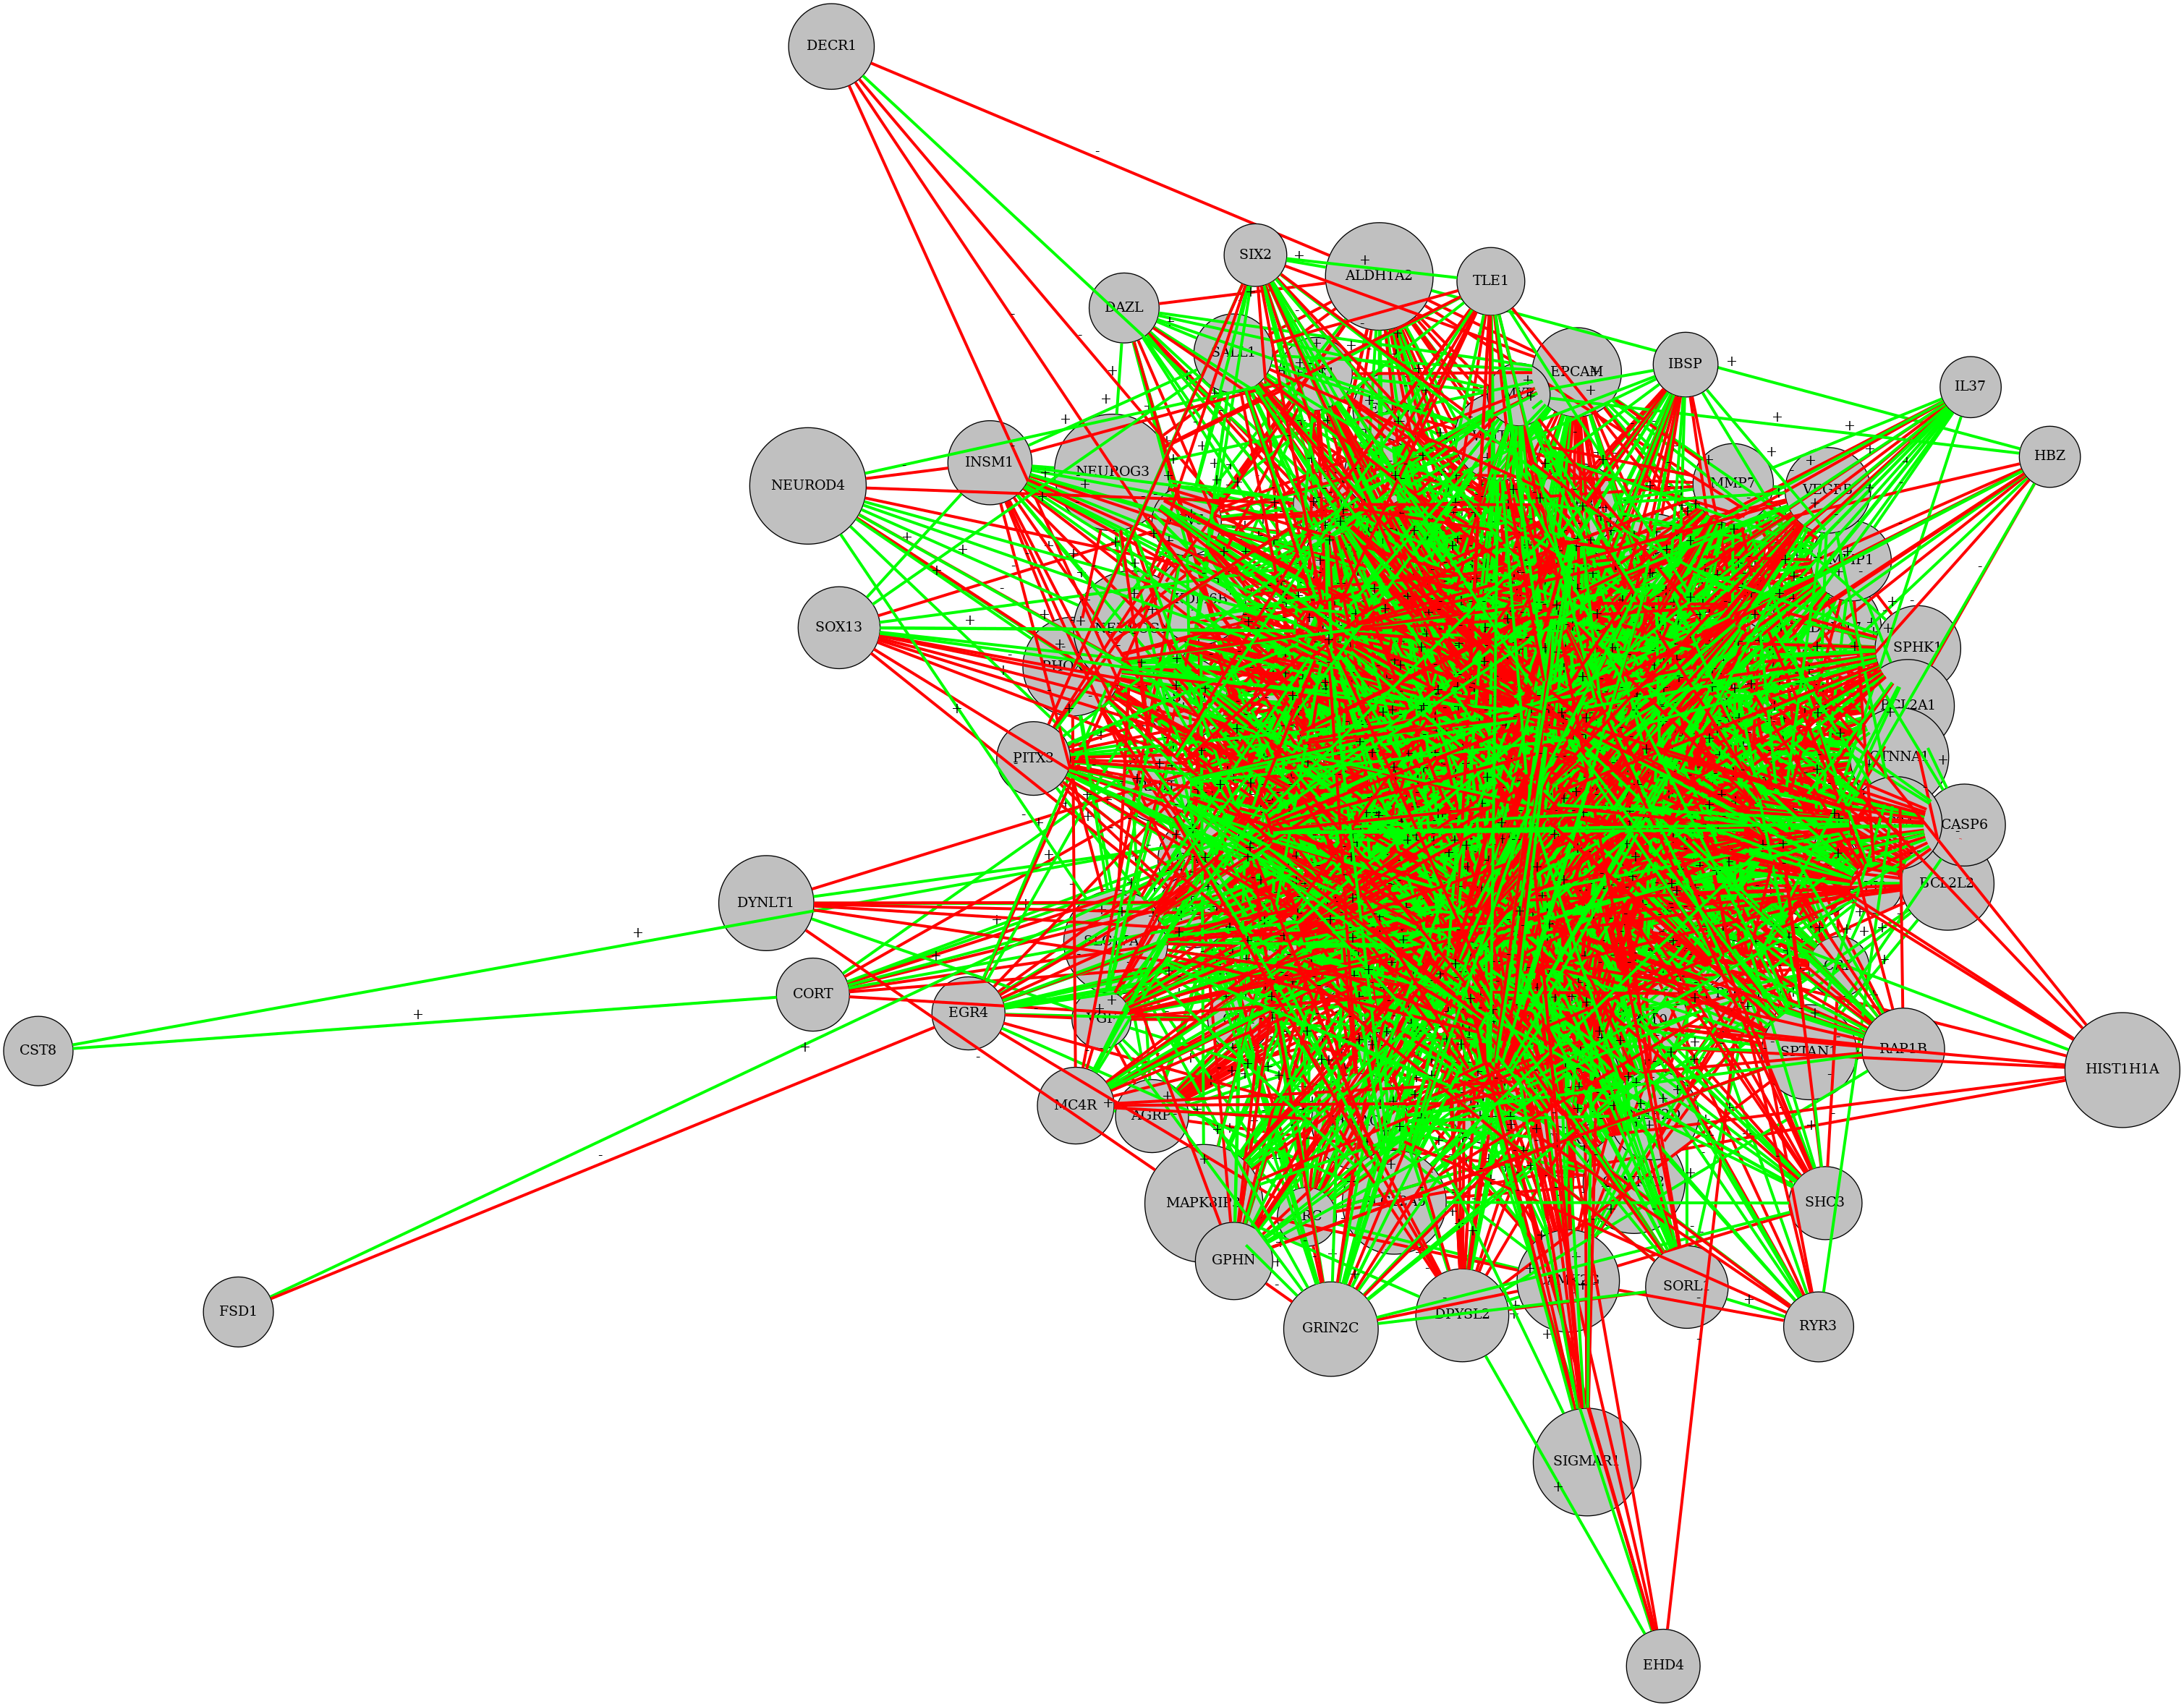

In [22]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

In [23]:
with open(file_folder+"solution.bnet", "r") as f:
    network = f.read()
print(network)

ADAM17 <- (!APP&!BCL2L1&BCL2L2&BDNF&CDH1&CDH2&CREB1&!CRK&!CTNNB1&!CTNND1&!CX3CL1&!CXCL12&!EDN1&!EGF&EGR1&F2&FOS&IGF1&!IL1B&!JUN&!KDR&!MMP9&!NGF&NOTCH1&NTRK1&NTRK2&!PIK3CA&!PLG&!RBPJ&SHC1&SHH&!SIRT1&SPHK1&!TGFB1&!TNF&TP53)|(CCND1&DCX&FGF2&LEP&MMP1&PI3&PLCG1)|(EGR2&EPCAM&HES1&MMP1&MMP7&SORL1&TGFB2)
ADRB2 <- !BCL2L1|GNB2L1|(AGRP&!APP&!BCL2A1&BDNF&!CCND1&CDH1&!CREB1&!CREBBP&CRH&CTNNB1&!CX3CL1&!CXCL12&DUSP1&!EDN1&!EDN3&!EGF&EGR1&F2&!FGF2&FOS&GDNF&HTT&!IGF1&!IL1B&ITPR1&!JUN&KDR&LEP&MAPK10&!MC4R&MEF2C&MMP1&!MMP7&!MMP9&NGF&NOTCH1&!NTRK1&NTRK2&!PLG&PRKACA&RHO&RYR3&!SHC1&!SIRT1&!SNCA&SORL1&!SST&!TGFB1&!TNF&TP53&TRPV1&!VEGFB)
AGRP <- NEUROG3|SHH|(ADRB2&APP&!BDNF&!CAMKK2&!CREB1&CRH&FOS&IGF1&!IL1B&!JUN&LEP&MC4R&!NGF&!NTRK2&PHOX2B&!PIK3CA&RHO&!SIRT1&SST&!TNF&!TP53&TRPV1&!VGF)
ALDH1A2 <- !KDR|(CCND1&!CDH1&CDH2&CTNNB1&CXCL12&!DAZL&!DECR1&!EGF&!EGR2&!EPCAM&!F2&!GDNF&GNB2L1&HBZ&IGF1&!IL1B&MEF2C&!NEUROG1&!NEUROG3&!NOTCH1&PHOX2B&!PITX3&!RBPJ&RET&!SALL1&!SHH&SIX2&!TGFB1&!TGFB2&!TNF&TP53&!WNT11)|(ETV4&FGF2)

## Detection of Master Regulators (NORDic PMR)

On a dummy example.

In [24]:
import os
import numpy as np
import pandas as pd
from subprocess import call as sbcall
from glob import glob

from NORDic.UTILS.utils_plot import influences2graph
from NORDic.NORDic_PMR.functions import greedy

Create network

In [25]:
## Test: we expect X0 and X1 to be outputed, X10 to have no influence on the network because it is isolated
source = list(map(lambda x: "X%d" % x,[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]))#,0]))
target = list(map(lambda x : "X%d" % x,[2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]))#,11]))
genes = list(sorted(list(set(source+target))))+["X10"]

In [26]:
save_folder="MODELS/minimal/"
sbcall("mkdir -p "+save_folder, shell=True)

0

### Plot network

In [27]:
influences = np.zeros((len(genes), len(genes)))
for s, t in zip(source, target):
    influences[genes.index(s)][genes.index(t)] = 1
influences = pd.DataFrame(influences, index=genes, columns=genes)
influences2graph(influences, save_folder+"example", optional=False, compile2png=True, engine="sfdp")

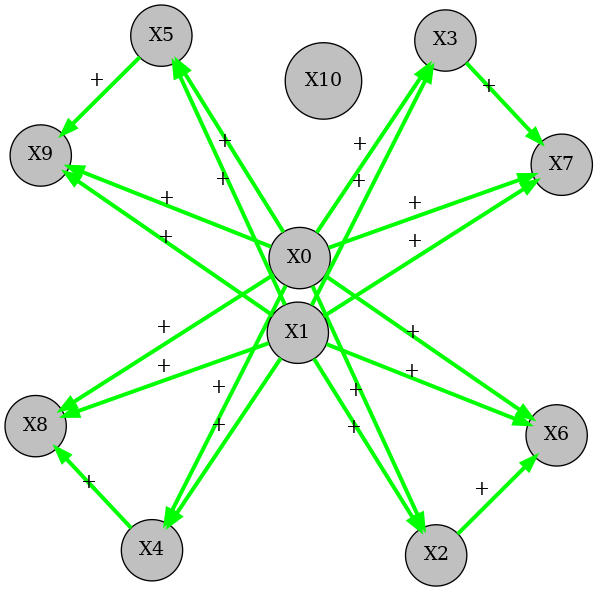

In [28]:
from IPython.display import Image
Image(filename=save_folder+'example.png') 

### Build network

In [29]:
grfs = {}
for si, s in enumerate(source):
    t = target[si]
    grf = grfs.get(t, [])
    grfs.update(dict([[t, list(set(grf+[s]))]]))
with open(save_folder+"example.bnet", "w") as f:
    network = []
    for g in genes:
        if (g in grfs):
            network += [g+", "+"&".join(grfs[g])]
        else:
            network += [g+", 1"]
    f.write("\n".join(network))

In [30]:
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
print("\n".join([" <- ".join(s.split(", ")) for s in network.split("\n")]))

X0 <- 1
X1 <- 1
X2 <- X1&X0
X3 <- X1&X0
X4 <- X1&X0
X5 <- X1&X0
X6 <- X1&X2&X0
X7 <- X1&X0&X3
X8 <- X1&X4&X0
X9 <- X5&X1&X0
X10 <- 1


In [31]:
gene_outputs = [x.split(", ")[0] for x in network.split("\n")[:-1] if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

### Sample states at random

In [32]:
state_len = 100
states = pd.DataFrame([np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)], columns=genes, index=range(state_len)).T
states

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
X0    1   1   0   0   0   1   0   1   1   1   0   1   0   1   0   1   1   0   
X1    0   0   1   0   1   1   0   1   1   1   1   0   0   1   1   0   0   0   
X2    1   1   0   0   0   0   0   0   0   1   1   1   1   1   1   0   0   0   
X3    1   1   0   0   1   1   1   1   0   0   0   0   1   0   1   1   1   0   
X4    0   1   1   1   0   0   0   1   0   0   0   1   1   0   0   1   0   1   
X5    0   1   1   0   0   1   0   1   1   1   0   0   1   1   0   1   1   0   
X6    0   0   1   1   0   1   0   0   0   1   0   0   0   0   0   1   0   0   
X7    1   1   1   1   0   1   1   0   0   1   0   1   1   0   0   1   0   1   
X8    0   1   1   1   1   1   0   0   1   0   1   0   1   0   0   1   1   0   
X9    0   1   1   0   0   0   0   0   0   0   0   0   1   1   0   1   1   1   
X10   1   0   1   1   0   0   1   0   0   1   0   1   1   1   1   0   0   1   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
X0    0   1   0   1   1   1   1   0   1   1   1   0   1   1   0   1   0   0   
X1    0   0   1   1   0   1   0   1   0   0   1   1   0   1   1   0   1   0   
X2    1   1   0   1   0   0   0   0   0   0   0   0   0   1   0   0   1   0   
X3    1   1   0   1   1   0   1   1   0   1   1   0   1   0   0   1   1   1   
X4    0   0   1   0   1   1   1   0   0   0   1   1   1   1   0   0   0   0   
X5    1   1   0   0   0   1   1   1   1   1   0   0   1   0   1   1   1   0   
X6    0   0   0   0   1   1   1   0   0   1   1   0   1   0   1   1   0   0   
X7    0   0   1   1   0   0   1   1   1   1   1   1   0   1   1   0   0   0   
X8    1   0   0   1   1   0   1   1   1   0   1   1   1   1   0   1   1   0   
X9    1   0   1   0   0   0   0   0   1   0   0   0   1   1   0   0   1   0   
X10   1   0   0   0   1   1   0   0   1   0   0   0   1   1   1   1   1   1   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
X0    0   1   1   1   0   1   0   0   1   0   0   1   1   1   1   1   1   1   
X1    1   1   0   1   0   0   1   1   1   1   0   1   0   0   1   0   0   0   
X2    0   1   0   1   0   1   1   1   1   0   0   0   0   0   1   0   0   1   
X3    0   1   0   1   1   1   0   1   0   1   0   0   1   0   0   0   0   0   
X4    0   0   0   1   1   0   0   1   1   0   1   1   0   0   1   1   1   1   
X5    1   0   0   1   1   0   1   0   1   0   1   1   1   0   1   0   1   0   
X6    1   1   1   1   0   1   0   0   0   0   0   0   0   1   1   0   1   1   
X7    1   1   1   1   1   1   1   0   0   0   1   1   0   1   1   0   0   0   
X8    1   1   1   0   0   0   1   0   0   0   1   1   1   0   1   0   0   0   
X9    1   0   0   0   1   0   1   0   1   1   0   1   0   0   0   0   1   0   
X10   0   1   1   1   1   0   1   1   0   1   0   1   0   0   0   1   0   0   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
X0    0   0   0   0   0   0   0   1   0   1   0   1   1   1   0   1   1   1   
X1    1   1   1   0   1   0   0   1   1   0   0   0   1   1   1   1   0   1   
X2    0   0   0   1   0   1   0   0   1   0   0   1   0   1   0   1   1   1   
X3    1   1   1   0   0   0   0   1   1   0   1   1   1   1   1   1   0   0   
X4    0   1   1   0   1   0   1   1   1   1   1   0   0   0   1   1   1   1   
X5    1   0   0   0   0   0   1   1   1   0   1   0   1   1   1   1   1   1   
X6    0   0   0   0   1   0   1   0   1   0   1   0   1   0   1   0   0   0   
X7    1   1   0   1   1   0   0   0   0   0   1   0   0   1   1   1   1   0   
X8    1   1   1   1   0   0   1   0   1   0   1   1   1   0   0   1   1   0   
X9    0   0   1   1   0   0   0   1   1   0   0   1   0   0   0   0   0   0   
X10   1   1   0   1   1   0   1   1   0   1   0   0   0   1   0   1   1   0   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  \
X0    1   1   0   0   0   0   1   1   1   0   0   1   1   0   0   1   1   1   
X1    0   1   1   0   0   1   0   0   1   0   1   1

### Parameters

In [33]:
seed_number=0
k=2

from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)

IM_params = {
    "seed": seed_number,
    "njobs": min(5, njobs),
    "gene_inputs": genes, # genes to be perturbed
    "gene_outputs": gene_outputs # genes to be observed
}
SIMU_params = {
    'nb_sims': 100,
    'rates': "fully_asynchronous",
    'thread_count': njobs,
    'depth': "constant_unitary",
}

### Detection of master regulators

In [34]:
S, spreads = greedy(save_folder+"example.bnet", k, states, IM_params, SIMU_params, save_folder=save_folder)

<NORD_PMR> Iteration k=2
	<NORD_PMR> Initial state 3
	<NORD_PMR> Initial state 4
	<NORD_PMR> Initial state 1
	<NORD_PMR> Initial state 2
	<NORD_PMR> Initial state 0
1 wild type attractors (initial state 1)
Chunk (1/11)
1 wild type attractors (initial state 4)
Chunk (1/11)
1 wild type attractors (initial state 3)
Chunk (1/11)
1 wild type attractors (initial state 0)
Chunk (1/11)
1 wild type attractors (initial state 2)
Chunk (1/11)
0 new mutant X0_OE {[]} attractors (1/1) (initial state 4)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 3)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 1)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 0)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 2)
* 

100%|██████████| 1/1 [00:00<00:00, 29127.11it/s]


100%|██████████| 1/1 [00:00<00:00, 48770.98it/s]

100%|██████████| 1/1 [00:00<00:00, 28926.23it/s]


100%|██████████| 100/100 [00:00<00:00, 34964.19it/s]


100%|██████████| 1/1 [00:00<00:00, 41527.76it/s]


100%|██████████| 100/100 [00:00<00:00, 38395.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]

100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]

100%|██████████| 100/100 [00:00<00:00, 31755.78it/s]

100%|██████████| 100/100 [00:00<00:00, 51800.72it/s]

100%|██████████| 1/1 [00:00<00:00, 40329.85it/s]


100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]

100%|██████████| 1/1 [00:00<00:00, 42366.71it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 38882.95it/s]

100%|██████████| 1/1 [00:00<00:00, 42366.71it/s]

100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]

	<NORD_PMR> Initial state 5
	<NORD_PMR> Initial state 7
	<NORD_PMR> Initial state 6
1 wild type attractors (initial state 5)
Chunk (1/11)
	<NORD_PMR> Initial state 8
1 wild type attractors (initial state 7)
Chunk (1/11)
1 wild type attractors (initial state 6)
Chunk (1/11)
	<NORD_PMR> Initial state 9
1 new mutant X0_KO {[]} attractors (1/1) (initial state 5)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 8)
Chunk (1/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 7)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 6)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 9)
Chunk (1/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 8)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 9)
* X0_KO {[]}	- constant_uni


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 20504.03it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 43690.67it/s]

100%|██████████| 100/100 [00:00<00:00, 32496.35it/s]

100%|██████████| 1/1 [00:00<00:00, 21732.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 39568.91it/s]

100%|██████████| 1/1 [00:00<00:00, 30615.36it/s]

1 new mutant X10_KO {[]} attractors (1/1) (initial state 9)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 10)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 11
	<NORD_PMR> Initial state 12
1 wild type attractors (initial state 11)
Chunk (1/11)
1 wild type attractors (initial state 12)
Chunk (1/11)
	<NORD_PMR> Initial state 13
0 new mutant X0_OE {[]} attractors (1/1) (initial state 12)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 11)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
	<NORD_PMR> Initial state 14
1 new mutant X1_KO {[]} attractors (1/1) (initial state 10)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 13)
Chunk (1/11)
1 wild type attractors (initial state 14)
Chunk (1/11)
Chunk (2/11)
0 


100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]

100%|██████████| 100/100 [00:00<00:00, 36217.11it/s]

100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 43690.67it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 49315.74it/s]

100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]

100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]

100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]

100%|██████████| 1/1 [00:00<00:00, 44150.57it/s]

100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


100%|██████████| 100/100 [00:00<00:00, 38022.88it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 42366.71it/s]

100%|██████████| 100/100 [00:00<00:00, 46832.34it/s]

1 new mutant X1_KO {[]} attractors (1/1) (initial state 20)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 22
	<NORD_PMR> Initial state 23
Chunk (11/11)
1 wild type attractors (initial state 22)
Chunk (1/11)
0 new mutant X10_OE {[]} attractors (1/1) (initial state 19)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 22)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
1 wild type attractors (initial state 23)
Chunk (1/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 21)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X2_OE {[]} attractors (1/1) (initial state 20)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 23)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 24


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 42366.71it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 38625.14it/s]


100%|██████████| 100/100 [00:00<00:00, 37943.77it/s]

100%|██████████| 100/100 [00:00<00:00, 43495.84it/s]

100%|██████████| 100/100 [00:00<00:00, 30863.16it/s]

100%|██████████| 100/100 [00:00<00:00, 38836.15it/s]


100%|██████████| 100/100 [00:00<00:00, 36270.36it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]

100%|██████████| 100/100 [00:00<00:00, 34331.70it/s]


100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]

	<NORD_PMR> Initial state 33
0 new mutant X0_OE {[]} attractors (1/1) (initial state 32)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
1 wild type attractors (initial state 33)
Chunk (1/11)
0 new mutant X2_OE {[]} attractors (1/1) (initial state 30)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
	<NORD_PMR> Initial state 34
1 new mutant X0_KO {[]} attractors (1/1) (initial state 33)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_KO {[]} attractors (1/1) (initial state 31)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
1 wild type attractors (initial state 34)
Chunk (1/11)
Chunk (4/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 32)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X3_KO {[]} attractors (1/1) (initial state 30)
* X3_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE

100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]

100%|██████████| 100/100 [00:00<00:00, 30504.03it/s]

100%|██████████| 100/100 [00:00<00:00, 33015.62it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0 new mutant X0_OE {[]} attractors (1/1) (initial state 36)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 37)
Chunk (1/11)
	<NORD_PMR> Initial state 38
Chunk (3/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 37)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
1 wild type attractors (initial state 38)
Chunk (1/11)
0 new mutant X2_OE {[]} attractors (1/1) (initial state 35)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_KO {[]} attractors (1/1) (initial state 34)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 38)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 36)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
Chunk (4/11)
	<NORD_PMR> Initial state 39
1 


100%|██████████| 1/1 [00:00<00:00, 42799.02it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

100%|██████████| 100/100 [00:00<00:00, 41347.63it/s]

100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]

100%|██████████| 100/100 [00:00<00:00, 33789.61it/s]

100%|██████████| 1/1 [00:00<00:00, 43690.67it/s]

100%|██████████| 100/100 [00:00<00:00, 30435.41it/s]

100%|██████████| 1/1 [00:00<00:00, 40721.40it/s]

100%|██████████| 100/100 [00:00<00:00, 31876.46it/s]

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

100%|██████████| 1/1 [00:00<00:00, 47662.55it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

100%|██████████| 100/100 [00:00<00:00, 34897.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 42
1 wild type attractors (initial state 41)
Chunk (1/11)
Chunk (11/11)
1 wild type attractors (initial state 42)
Chunk (1/11)
Chunk (11/11)
1 new mutant X10_KO {[]} attractors (1/1) (initial state 38)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 41)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
0 new mutant X0_OE {[]} attractors (1/1) (initial state 42)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_KO {[]} attractors (1/1) (initial state 39)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X2_OE {[]} attractors (1/1) (initial state 40)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
	<NORD_PMR> Initial state 43
Chunk (2/11)
	<NORD_PMR> Initial state 44
0 new mutant X1_OE {[]} attractors (1/1) (initial state 41)
* X1_OE {[]}	- constant_unitary_depth

100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 31103.48it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 25400.01it/s]

100%|██████████| 1/1 [00:00<00:00, 26051.58it/s]

Chunk (2/11)
Chunk (2/11)
	<NORD_PMR> Initial state 48
Chunk (3/11)
	<NORD_PMR> Initial state 49
0 new mutant X1_OE {[]} attractors (1/1) (initial state 46)
* X1_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_KO {[]} attractors (1/1) (initial state 47)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X2_OE {[]} attractors (1/1) (initial state 45)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 48)
Chunk (1/11)
1 wild type attractors (initial state 49)
Chunk (1/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 48)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 49)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
Chunk (3/11)
0 new mutant X2_OE {[]} attractors (1/1) (initial state 46)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk


100%|██████████| 100/100 [00:00<00:00, 39177.13it/s]

100%|██████████| 1/1 [00:00<00:00, 41943.04it/s]

100%|██████████| 100/100 [00:00<00:00, 27967.62it/s]

100%|██████████| 1/1 [00:00<00:00, 21399.51it/s]

100%|██████████| 100/100 [00:00<00:00, 29328.75it/s]

100%|██████████| 100/100 [00:00<00:00, 32541.73it/s]

100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]

100%|██████████| 100/100 [00:00<00:00, 27264.07it/s]

1 wild type attractors (initial state 52)
Chunk (1/11)
Chunk (11/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 50)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 53
Chunk (2/11)
0 new mutant X10_OE {[]} attractors (1/1) (initial state 49)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 52)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X1_OE {[]} attractors (1/1) (initial state 51)
* X1_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 53)
Chunk (1/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 53)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
	<NORD_PMR> Initial state 54
1 new mutant X2_KO {[]} attractors (1/1) (initial state 50)
* X2_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
1 wild type att


100%|██████████| 100/100 [00:00<00:00, 20633.14it/s]

100%|██████████| 100/100 [00:00<00:00, 26336.20it/s]

100%|██████████| 100/100 [00:00<00:00, 34787.29it/s]

100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 30761.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 38419.93it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 34495.47it/s]

100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]

100%|██████████| 100/100 [00:00<00:00, 40140.72it/s]

100%|██████████| 100/100 [00:00<00:00, 36415.21it/s]

100%|██████████| 100/100 [00:00<00:00, 40129.20it/s]

100%|██████████| 100/100 [00:00<00:00, 37580.00it/s]

100%|██████████| 100/100 [00:00<00:00, 47190.64it/s]

1 new mutant X1_KO {[]} attractors (1/1) (initial state 55)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
	<NORD_PMR> Initial state 57
1 new mutant X10_KO {[]} attractors (1/1) (initial state 54)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
	<NORD_PMR> Initial state 58
1 wild type attractors (initial state 57)
Chunk (1/11)
Chunk (3/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 56)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X2_OE {[]} attractors (1/1) (initial state 55)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 57)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 58)
Chunk (1/11)
	<NORD_PMR> Initial state 59
0 new mutant X0_OE {[]} attractors (1/1) (initial state 58)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 46284.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 34202.92it/s]

100%|██████████| 1/1 [00:00<00:00, 40329.85it/s]

100%|██████████| 100/100 [00:00<00:00, 57701.25it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

1 wild type attractors (initial state 62)
Chunk (1/11)
0 new mutant X0_OE {[]} attractors (1/1) (initial state 62)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
Chunk (3/11)
	<NORD_PMR> Initial state 63
Chunk (11/11)
0 new mutant X2_OE {[]} attractors (1/1) (initial state 60)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_KO {[]} attractors (1/1) (initial state 61)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 63)
Chunk (1/11)
0 new mutant X10_OE {[]} attractors (1/1) (initial state 59)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 63)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_KO {[]} attractors (1/1) (initial state 62)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (4/11)
Chunk (3/11)
0 new mutant X3_OE


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 48731.31it/s]

100%|██████████| 100/100 [00:00<00:00, 46340.78it/s]

100%|██████████| 100/100 [00:00<00:00, 37985.00it/s]

1 wild type attractors (initial state 67)
Chunk (1/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 66)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 67)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X9_OE {[]} attractors (1/1) (initial state 64)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
Chunk (3/11)
1 new mutant X10_KO {[]} attractors (1/1) (initial state 63)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
1 new mutant X2_KO {[]} attractors (1/1) (initial state 65)
* X2_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 66)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 67)
* X1_KO {[]}	- constant_unitary_depth{}	

100%|██████████| 100/100 [00:00<00:00, 41270.33it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 35045.99it/s]

100%|██████████| 1/1 [00:00<00:00, 44150.57it/s]

Chunk (2/11)
0 new mutant X9_OE {[]} attractors (1/1) (initial state 69)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X2_KO {[]} attractors (1/1) (initial state 70)
* X2_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 71)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 72)
Chunk (1/11)
0 new mutant X10_OE {[]} attractors (1/1) (initial state 68)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X0_KO {[]} attractors (1/1) (initial state 72)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
Chunk (4/11)
Chunk (3/11)
1 new mutant X10_KO {[]} attractors (1/1) (initial state 69)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X3_OE {[]} attractors (1/1) (initial state 70)
* X3_OE {[]}	- constant_unitary_depth{}	fully_asynch


100%|██████████| 1/1 [00:00<00:00, 26886.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 22511.29it/s]

100%|██████████| 100/100 [00:00<00:00, 32567.00it/s]

100%|██████████| 100/100 [00:00<00:00, 31861.93it/s]

100%|██████████| 100/100 [00:00<00:00, 34958.36it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Chunk (3/11)
Chunk (11/11)
0 new mutant X2_OE {[]} attractors (1/1) (initial state 75)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/11)
Chunk (2/11)
	<NORD_PMR> Initial state 77
0 new mutant X10_OE {[]} attractors (1/1) (initial state 73)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X1_OE {[]} attractors (1/1) (initial state 76)
* X1_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_KO {[]} attractors (1/1) (initial state 74)
* X9_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 77)
Chunk (1/11)
Chunk (4/11)
0 new mutant X0_OE {[]} attractors (1/1) (initial state 77)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 78
1 new mutant X3_KO {[]} attractors (1/1) (initial state 75)
* X3_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/11)
1 wild type attractors (initial state 78)
C

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 37936.90it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0 new mutant X9_OE {[]} attractors (1/1) (initial state 77)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/11)
1 new mutant X1_KO {[]} attractors (1/1) (initial state 80)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X7_OE {[]} attractors (1/1) (initial state 79)
* X7_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X9_OE {[]} attractors (1/1) (initial state 78)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 81
Chunk (11/11)
Chunk (3/11)
1 wild type attractors (initial state 81)
Chunk (1/11)
Chunk (9/11)
1 new mutant X10_KO {[]} attractors (1/1) (initial state 77)
* X10_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X2_KO {[]} attractors (1/1) (initial state 80)
* X2_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 81)
* X0_OE {[]}	- constant_unitary_depth{

100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]

100%|██████████| 100/100 [00:00<00:00, 42094.58it/s]

100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]

100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 20661.60it/s]

100%|██████████| 100/100 [00:00<00:00, 34978.77it/s]

100%|██████████| 100/100 [00:00<00:00, 34003.28it/s]

100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1 new mutant X1_KO {[]} attractors (1/1) (initial state 85)
* X1_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_KO {[]} attractors (1/1) (initial state 82)
* X9_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/11)
	<NORD_PMR> Initial state 86
Chunk (9/11)
Chunk (3/11)
1 new mutant X9_KO {[]} attractors (1/1) (initial state 83)
* X9_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X8_KO {[]} attractors (1/1) (initial state 84)
* X8_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X2_KO {[]} attractors (1/1) (initial state 85)
* X2_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
1 wild type attractors (initial state 86)
Chunk (1/11)
0 new mutant X0_OE {[]} attractors (1/1) (initial state 86)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_KO {[]} attractors (1/1) (initial state 82)
* X10_KO {[]}	- constant_unitary_depth{


100%|██████████| 1/1 [00:00<00:00, 26886.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 36500.77it/s]

100%|██████████| 1/1 [00:00<00:00, 29746.84it/s]

100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

100%|██████████| 100/100 [00:00<00:00, 40333.72it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Chunk (10/11)
Chunk (10/11)
Chunk (3/11)
0 new mutant X9_OE {[]} attractors (1/1) (initial state 87)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/11)
0 new mutant X9_OE {[]} attractors (1/1) (initial state 88)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X2_OE {[]} attractors (1/1) (initial state 90)
* X2_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 91
1 new mutant X8_KO {[]} attractors (1/1) (initial state 89)
* X8_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 91)
Chunk (1/11)
Chunk (11/11)
Chunk (11/11)
Chunk (4/11)
1 new mutant X0_KO {[]} attractors (1/1) (initial state 91)
* X0_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X10_OE {[]} attractors (1/1) (initial state 87)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X10_OE {[]} attractors (1/1) (initial state 


100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]

100%|██████████| 1/1 [00:00<00:00, 26715.31it/s]

100%|██████████| 100/100 [00:00<00:00, 35356.18it/s]

100%|██████████| 100/100 [00:00<00:00, 36634.68it/s]

100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]

100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Chunk (9/11)
	<NORD_PMR> Initial state 96
0 new mutant X8_OE {[]} attractors (1/1) (initial state 94)
* X8_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
Chunk (10/11)
1 wild type attractors (initial state 96)
Chunk (1/11)
Chunk (4/11)
0 new mutant X10_OE {[]} attractors (1/1) (initial state 92)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X3_OE {[]} attractors (1/1) (initial state 95)
* X3_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X0_OE {[]} attractors (1/1) (initial state 96)
* X0_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X9_OE {[]} attractors (1/1) (initial state 93)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/11)
0 new mutant X9_OE {[]} attractors (1/1) (initial state 94)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 97
Chunk (5/11)
Chunk (2/11)
1 wild type attractors (initi

100%|██████████| 100/100 [00:00<00:00, 34390.82it/s]


100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]

100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]

100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]

100%|██████████| 100/100 [00:00<00:00, 41713.62it/s]

Chunk (10/11)
0 new mutant X9_OE {[]} attractors (1/1) (initial state 98)
* X9_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/11)
Chunk (11/11)
1 new mutant X9_KO {[]} attractors (1/1) (initial state 99)
* X9_KO {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X10_OE {[]} attractors (1/1) (initial state 98)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (11/11)
0 new mutant X10_OE {[]} attractors (1/1) (initial state 99)
* X10_OE {[]}	- constant_unitary_depth{}	fully_asynchronous_rates{}
* S = [] (all states)
        0     1     2     3     4     5     6     7     8     9    10    11  \
X0   1.00  1.00  0.00  0.00  0.00  1.00  0.00  1.00  1.00  1.00  0.00  1.00   
X1   0.00  0.00  1.00  0.00  1.00  1.00  0.00  1.00  1.00  1.00  1.00  0.00   
X10  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
X2   0.14  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.14  0.14  0.14   
X3   0.14  0.14


100%|██████████| 100/100 [00:00<00:00, 57275.76it/s]

100%|██████████| 100/100 [00:00<00:00, 37749.11it/s]

100%|██████████| 100/100 [00:00<00:00, 29512.41it/s]

100%|██████████| 100/100 [00:00<00:00, 28952.19it/s]

100%|██████████| 100/100 [00:00<00:00, 35818.14it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]

100%|██████████| 1/1 [00:00<00:00, 28149.69it/s]


100%|██████████| 100/100 [00:00<00:00, 35234.41it/s]

100%|██████████| 100/100 [00:00<00:00, 32587.24it/s]

Chunk (5/10)
Chunk (5/10)
Chunk (5/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 1)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 2)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X5_OE {['X0']} attractors (1/1) (initial state 0)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X5_OE {['X0']} attractors (1/1) (initial state 3)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
0 new mutant X5_OE {['X0']} attractors (1/1) (initial state 4)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
Chunk (6/10)
Chunk (6/10)
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 1)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 0)
* X6_OE {['X0']}


100%|██████████| 1/1 [00:00<00:00, 30393.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 33756.97it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]

100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]

Chunk (4/10)
Chunk (4/10)
1 new mutant X4_OE {['X0']} attractors (1/1) (initial state 8)
* X4_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X4_OE {['X0']} attractors (1/1) (initial state 9)
* X4_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X4_OE {['X0']} attractors (1/1) (initial state 6)
* X4_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 5)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
Chunk (5/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 7)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 8)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 9)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_async

100%|██████████| 100/100 [00:00<00:00, 45197.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 41527.76it/s]

100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


Chunk (4/10)
Chunk (5/10)
1 new mutant X4_OE {['X0']} attractors (1/1) (initial state 16)
* X4_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (4/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 12)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
Chunk (5/10)
0 new mutant X4_OE {['X0']} attractors (1/1) (initial state 18)
* X4_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X5_OE {['X0']} attractors (1/1) (initial state 14)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X5_OE {['X0']} attractors (1/1) (initial state 10)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
Chunk (6/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 16)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
0 new mutant X6_OE {['X0']} attractors (1/1) (initial state 12)
* X6_OE {['X0']}	- con

100%|██████████| 100/100 [00:00<00:00, 55268.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 36792.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 46603.38it/s]

100%|██████████| 100/100 [00:00<00:00, 55166.43it/s]

100%|██████████| 100/100 [00:00<00:00, 37025.99it/s]

100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 44323.20it/s]

Chunk (5/10)
Chunk (5/10)
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 13)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X5_OE {['X0']} attractors (1/1) (initial state 17)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
1 new mutant X5_OE {['X0']} attractors (1/1) (initial state 11)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 19)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X6_KO {['X0']} attractors (1/1) (initial state 15)
* X6_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
Chunk (6/10)
1 new mutant X7_OE {['X0']} attractors (1/1) (initial state 13)
* X7_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X6_OE {['X0']} attractors (1/1) (initial state 17)
* X6_OE {['X0']}	- constant_unitary_depth{}	full


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 45046.76it/s]

100%|██████████| 100/100 [00:00<00:00, 37650.84it/s]

100%|██████████| 100/100 [00:00<00:00, 32559.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 17770.22it/s]

100%|██████████| 100/100 [00:00<00:00, 35508.84it/s]

Chunk (7/10)
1 new mutant X6_KO {['X0']} attractors (1/1) (initial state 24)
* X6_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 20)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
Chunk (7/10)
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 26)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
1 new mutant X7_OE {['X0']} attractors (1/1) (initial state 22)
* X7_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X5_OE {['X0']} attractors (1/1) (initial state 28)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
Chunk (8/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 24)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
Chunk (8/10)
0 new mutant X8_OE {['X0']} attractors (1/1) (initial state 20)
* X8_OE {['X0']}	- con


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16194.22it/s]

100%|██████████| 100/100 [00:00<00:00, 36176.51it/s]

100%|██████████| 100/100 [00:00<00:00, 39801.71it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 37272.76it/s]

100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]

100%|██████████| 1/1 [00:00<00:00, 34952.53it/s]

Chunk (7/10)
Chunk (8/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 25)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
1 new mutant X8_OE {['X0']} attractors (1/1) (initial state 23)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 27)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
0 new mutant X6_OE {['X0']} attractors (1/1) (initial state 29)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
Chunk (8/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 21)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/10)
Chunk (8/10)
1 new mutant X8_KO {['X0']} attractors (1/1) (initial state 25)
* X8_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X8_OE {['X0']} attractors (1/1) (initial state 27)
* X8_OE {['X0']}	- con

100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

100%|██████████| 100/100 [00:00<00:00, 41672.17it/s]

100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]

100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]

100%|██████████| 100/100 [00:00<00:00, 39180.79it/s]

100%|██████████| 1/1 [00:00<00:00, 45100.04it/s]

100%|██████████| 100/100 [00:00<00:00, 43253.62it/s]


Chunk (6/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 32)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X6_KO {['X0']} attractors (1/1) (initial state 38)
* X6_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
Chunk (8/10)
1 new mutant X6_KO {['X0']} attractors (1/1) (initial state 36)
* X6_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (8/10)
Chunk (9/10)
1 new mutant X8_KO {['X0']} attractors (1/1) (initial state 34)
* X8_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
0 new mutant X8_OE {['X0']} attractors (1/1) (initial state 32)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_KO {['X0']} attractors (1/1) (initial state 30)
* X9_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 38)
* X7_KO {['X0']}	- constant_unitary_depth{}	full

100%|██████████| 100/100 [00:00<00:00, 33327.80it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 44150.57it/s]

100%|██████████| 100/100 [00:00<00:00, 43031.74it/s]

100%|██████████| 1/1 [00:00<00:00, 39945.75it/s]

100%|██████████| 100/100 [00:00<00:00, 45231.36it/s]

1 new mutant X8_KO {['X0']} attractors (1/1) (initial state 33)
* X8_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
Chunk (9/10)
Chunk (7/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 39)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_KO {['X0']} attractors (1/1) (initial state 31)
* X9_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 37)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (8/10)
Chunk (9/10)
0 new mutant X8_OE {['X0']} attractors (1/1) (initial state 35)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_OE {['X0']} attractors (1/1) (initial state 33)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (8/10)
Chunk (10/10)
Chunk (8/10)
1 new mutant X8_OE {['X0']} attractors (1/1) (initial state 39)
* X8_OE {['X0']}	- co


100%|██████████| 1/1 [00:00<00:00, 26715.31it/s]

100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]

100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]

100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]

100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]

100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]

100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 38868.54it/s]

Chunk (10/10)
Chunk (9/10)
Chunk (9/10)
1 new mutant X10_KO {['X0']} attractors (1/1) (initial state 42)
* X10_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/10)
0 new mutant X9_OE {['X0']} attractors (1/1) (initial state 46)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_KO {['X0']} attractors (1/1) (initial state 44)
* X9_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X9_OE {['X0']} attractors (1/1) (initial state 48)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 41
	<NORD_PMR> Initial state 43
Chunk (10/10)
Chunk (10/10)
1 wild type attractors (initial state 43)
Chunk (1/10)
Chunk (10/10)
1 wild type attractors (initial state 41)
Chunk (1/10)
0 new mutant X10_OE {['X0']} attractors (1/1) (initial state 46)
* X10_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_OE {['X0']} attractors (1/1) (initial sta


100%|██████████| 100/100 [00:00<00:00, 27696.14it/s]

100%|██████████| 100/100 [00:00<00:00, 39224.76it/s]

100%|██████████| 100/100 [00:00<00:00, 22569.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 43468.79it/s]

100%|██████████| 1/1 [00:00<00:00, 25575.02it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 33961.98it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 30963.41it/s]

Chunk (10/10)
1 wild type attractors (initial state 52)
Chunk (1/10)
1 new mutant X1_KO {['X0']} attractors (1/1) (initial state 50)
* X1_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/10)
1 new mutant X1_OE {['X0']} attractors (1/1) (initial state 52)
* X1_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_KO {['X0']} attractors (1/1) (initial state 47)
* X10_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_KO {['X0']} attractors (1/1) (initial state 45)
* X10_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 54
Chunk (2/10)
1 wild type attractors (initial state 54)
Chunk (1/10)
Chunk (2/10)
1 new mutant X2_KO {['X0']} attractors (1/1) (initial state 50)
* X2_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 56
1 new mutant X1_KO {['X0']} attractors (1/1) (initial state 54)
* X1_KO {['X0']}	- constant_unitary

100%|██████████| 100/100 [00:00<00:00, 27195.12it/s]

100%|██████████| 100/100 [00:00<00:00, 35418.88it/s]

100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 31352.25it/s]

100%|██████████| 1/1 [00:00<00:00, 26379.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 45590.26it/s]

100%|██████████| 1/1 [00:00<00:00, 46091.25it/s]


100%|██████████| 100/100 [00:00<00:00, 42581.77it/s]

Chunk (2/10)
1 wild type attractors (initial state 55)
Chunk (1/10)
0 new mutant X10_OE {['X0']} attractors (1/1) (initial state 56)
* X10_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X2_KO {['X0']} attractors (1/1) (initial state 53)
* X2_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_KO {['X0']} attractors (1/1) (initial state 55)
* X1_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/10)
1 new mutant X10_KO {['X0']} attractors (1/1) (initial state 58)
* X10_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/10)
1 new mutant X3_OE {['X0']} attractors (1/1) (initial state 51)
* X3_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/10)
Chunk (2/10)
	<NORD_PMR> Initial state 59
0 new mutant X2_OE {['X0']} attractors (1/1) (initial state 55)
* X2_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X3_OE {['X0']} attracto


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

100%|██████████| 100/100 [00:00<00:00, 47852.87it/s]

100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 25115.59it/s]

100%|██████████| 1/1 [00:00<00:00, 41120.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

100%|██████████| 100/100 [00:00<00:00, 32167.37it/s]

Chunk (3/10)
0 new mutant X3_OE {['X0']} attractors (1/1) (initial state 60)
* X3_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/10)
1 new mutant X3_KO {['X0']} attractors (1/1) (initial state 62)
* X3_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X2_OE {['X0']} attractors (1/1) (initial state 64)
* X2_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 68
	<NORD_PMR> Initial state 66
1 wild type attractors (initial state 68)
Chunk (1/10)
1 wild type attractors (initial state 66)
Chunk (1/10)
Chunk (4/10)
Chunk (4/10)
1 new mutant X1_KO {['X0']} attractors (1/1) (initial state 66)
* X1_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_KO {['X0']} attractors (1/1) (initial state 68)
* X1_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X4_KO {['X0']} attractors (1/1) (initial state 60)
* X4_KO {['X0']}	- constant_unitary_depth


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]

100%|██████████| 100/100 [00:00<00:00, 34655.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

100%|██████████| 100/100 [00:00<00:00, 34484.12it/s]

100%|██████████| 100/100 [00:00<00:00, 36980.29it/s]

1 new mutant X4_KO {['X0']} attractors (1/1) (initial state 61)
* X4_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/10)
Chunk (5/10)
1 new mutant X3_KO {['X0']} attractors (1/1) (initial state 65)
* X3_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (2/10)
Chunk (2/10)
1 new mutant X5_OE {['X0']} attractors (1/1) (initial state 63)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
1 new mutant X2_KO {['X0']} attractors (1/1) (initial state 69)
* X2_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 61)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X2_KO {['X0']} attractors (1/1) (initial state 67)
* X2_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (4/10)
Chunk (6/10)
1 new mutant X4_OE {['X0']} attractors (1/1) (initial state 65)
* X4_OE {['X0']}	- constant_unitary


100%|██████████| 100/100 [00:00<00:00, 42247.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 48132.94it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 45260.65it/s]


100%|██████████| 1/1 [00:00<00:00, 38836.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 40992.03it/s]

100%|██████████| 1/1 [00:00<00:00, 41527.76it/s]

1 new mutant X5_OE {['X0']} attractors (1/1) (initial state 72)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X4_KO {['X0']} attractors (1/1) (initial state 74)
* X4_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X2_OE {['X0']} attractors (1/1) (initial state 78)
* X2_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
Chunk (3/10)
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 70)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
0 new mutant X3_OE {['X0']} attractors (1/1) (initial state 76)
* X3_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (3/10)
1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 74)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X3_KO {['X0']} attractors (1/1) (initial state 78)
* X3_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chu


100%|██████████| 1/1 [00:00<00:00, 44620.26it/s]

100%|██████████| 1/1 [00:00<00:00, 39945.75it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]

100%|██████████| 100/100 [00:00<00:00, 40634.61it/s]

100%|██████████| 100/100 [00:00<00:00, 39692.48it/s]

100%|██████████| 100/100 [00:00<00:00, 40125.36it/s]

1 new mutant X7_OE {['X0']} attractors (1/1) (initial state 71)
* X7_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (4/10)
Chunk (6/10)
Chunk (4/10)
1 new mutant X4_KO {['X0']} attractors (1/1) (initial state 77)
* X4_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X6_OE {['X0']} attractors (1/1) (initial state 75)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X4_OE {['X0']} attractors (1/1) (initial state 79)
* X4_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
Chunk (8/10)
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 73)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X8_OE {['X0']} attractors (1/1) (initial state 71)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
Chunk (5/10)
Chunk (5/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 75)
* X7_KO {['X0']}	- con


100%|██████████| 100/100 [00:00<00:00, 38171.68it/s]

100%|██████████| 100/100 [00:00<00:00, 30446.46it/s]

100%|██████████| 1/1 [00:00<00:00, 41527.76it/s]

100%|██████████| 100/100 [00:00<00:00, 34540.92it/s]

100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]

100%|██████████| 100/100 [00:00<00:00, 42022.88it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Chunk (8/10)
Chunk (7/10)
1 new mutant X8_OE {['X0']} attractors (1/1) (initial state 80)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 82)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (5/10)
Chunk (5/10)
Chunk (7/10)
1 new mutant X5_OE {['X0']} attractors (1/1) (initial state 88)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X5_OE {['X0']} attractors (1/1) (initial state 86)
* X5_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 84)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/10)
Chunk (8/10)
1 new mutant X9_OE {['X0']} attractors (1/1) (initial state 80)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X8_KO {['X0']} attractors (1/1) (initial state 82)
* X8_KO {['X0']}	- constant_unitary

100%|██████████| 100/100 [00:00<00:00, 46208.04it/s]

100%|██████████| 100/100 [00:00<00:00, 48935.99it/s]

100%|██████████| 1/1 [00:00<00:00, 24672.38it/s]

100%|██████████| 100/100 [00:00<00:00, 40094.68it/s]

100%|██████████| 100/100 [00:00<00:00, 31891.00it/s]

100%|██████████| 1/1 [00:00<00:00, 41527.76it/s]

100%|██████████| 100/100 [00:00<00:00, 40279.50it/s]

100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]

100%|██████████| 100/100 [00:00<00:00, 45540.76it/s]

100%|██████████| 100/100 [00:00<00:00, 33651.35it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 43690.67it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1 new mutant X5_KO {['X0']} attractors (1/1) (initial state 87)
* X5_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (6/10)
Chunk (8/10)
1 new mutant X6_KO {['X0']} attractors (1/1) (initial state 89)
* X6_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X8_KO {['X0']} attractors (1/1) (initial state 85)
* X8_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/10)
Chunk (8/10)
Chunk (6/10)
0 new mutant X10_OE {['X0']} attractors (1/1) (initial state 81)
* X10_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X6_OE {['X0']} attractors (1/1) (initial state 87)
* X6_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (7/10)
1 new mutant X8_OE {['X0']} attractors (1/1) (initial state 83)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 89)
* X7_KO {['X0']}	- constant_unitary_depth{}	f


100%|██████████| 100/100 [00:00<00:00, 41323.19it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 24781.71it/s]

100%|██████████| 1/1 [00:00<00:00, 42799.02it/s]

100%|██████████| 100/100 [00:00<00:00, 47068.84it/s]

100%|██████████| 1/1 [00:00<00:00, 28532.68it/s]

100%|██████████| 100/100 [00:00<00:00, 42217.45it/s]

Chunk (9/10)
Chunk (7/10)
	<NORD_PMR> Initial state 91
1 new mutant X9_OE {['X0']} attractors (1/1) (initial state 92)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/10)
1 new mutant X7_KO {['X0']} attractors (1/1) (initial state 98)
* X7_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (8/10)
1 wild type attractors (initial state 91)
Chunk (1/10)
1 new mutant X9_OE {['X0']} attractors (1/1) (initial state 94)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X8_OE {['X0']} attractors (1/1) (initial state 96)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X1_OE {['X0']} attractors (1/1) (initial state 91)
* X1_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/10)
Chunk (8/10)
1 new mutant X10_OE {['X0']} attractors (1/1) (initial state 92)
* X10_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X8_OE {['X0'

0 new mutant X8_OE {['X0']} attractors (1/1) (initial state 99)
* X8_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
0 new mutant X9_OE {['X0']} attractors (1/1) (initial state 93)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/10)
Chunk (10/10)
0 new mutant X9_OE {['X0']} attractors (1/1) (initial state 97)
* X9_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
1 new mutant X10_KO {['X0']} attractors (1/1) (initial state 95)
* X10_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (9/10)
1 new mutant X9_KO {['X0']} attractors (1/1) (initial state 99)
* X9_KO {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/10)
0 new mutant X10_OE {['X0']} attractors (1/1) (initial state 97)
* X10_OE {['X0']}	- constant_unitary_depth{}	fully_asynchronous_rates{}
Chunk (10/10)
Chunk (10/10)
1 new mutant X10_KO {['X0']} attractors (1/1) (initial state 93)
* X10_KO {['X0']}	- constant_unitary_de


100%|██████████| 100/100 [00:00<00:00, 27745.61it/s]

In [35]:
S = [x for s in S for x in s]
assert all([s in ["X0","X1"] for s in S])

In [36]:
S

['X0', 'X1']

In [37]:
spreads

[['X0']]  [['X0'], ['X1']]
X0   0.464086          0.753211
X1   0.404445          0.753211
X2   0.052429          0.489238
X3   0.073319          0.506904
X4   0.071913          0.512839
X5   0.077546          0.506904
X6   0.000000          0.464086
X7   0.000000          0.464086
X8   0.000000          0.464086
X9   0.000000          0.464086
X10  0.000000          0.464086

As expected, nodes X0 and X1 are the most regulatory in this network.